#

In [36]:
import csv
import datetime
import fnmatch
import glob
import itertools
from itertools import groupby
import math
import matplotlib.cbook
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.polynomial.polynomial import polyfit
import os
import pandas as pd
import pickle
import platform
from pylab import rcParams
import re
import scipy
from scipy import stats
from scipy.ndimage import gaussian_filter as smooth
from scipy.ndimage import median_filter
from scipy.signal import find_peaks
import statistics
import sys
import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Define acquired data path. Load other notebooks if necessary.

In [37]:
###Set the notebook screen ratio for jupyter
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:85% !important; }</style>"))

notebookPath=os.path.dirname(os.path.realpath("__file__"))
#pathToProcessingNotebooks=os.path.join(os.path.split(notebookPath)[0],"load_preprocess_rat")
#os.chdir(pathToProcessingNotebooks)   
#%run loadRat_documentationmod.ipynb
#%run plotRat_documentation_1_GeneralBehaviormod.ipynb

#### DEFINE ROOT
#folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/testDist3Days1Rat"
    #root="/home/david/Desktop/DATARUN_ANALYSIS/test0727"#new/test1203"#DATARUN ANALYSIS/all distance" #all distances" #DATARUN ANALYSIS/test0820
    savePath="/home/david/Desktop/Save"
else:
    #mac = 'Darwin'.    20210106test
    root="/Users/tom/Desktop/DATAclean"#Downloads/DATATEST/20210211"#AET-2/test1203"#Desktop/DATARUN_ANALYSIS/test0826"#" #current : test0826
    savePath="/Users/tom/Desktop/Save"#os.path.join(root,"ALLRATS","Fig")
print("Root: ", root)

retval = os.getcwd()
print("Current working directory: %s" % retval)#print("Notebook Path: ", notebookPath)
print("Save Path: ", savePath)   
print("Path to data is: %s"%root)
print("")
print("importing done")

#choose whether to recompute all behav. General switch that will either recompute all or nothing. Can specify whether to redo or not in the specific computation cells.
redoAll_Override = True
if redoAll_Override is not None:
    if redoAll_Override == False:
        redoBoundKDE, redoExtractRuns_wBounds, redoMask, redoExtractRuns_wSpeed, redoExtractRunsBin_wSpeed = False, False, False, False, False
    if redoAll_Override == True:
        redoBoundKDE, redoExtractRuns_wBounds, redoMask, redoExtractRuns_wSpeed, redoExtractRunsBin_wSpeed = True, True, True, True, True

Root:  /home/david/Desktop/testDist3Days1Rat
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Path to data is: /home/david/Desktop/testDist3Days1Rat

importing done


# Define a few utility functions
# + details
# columns in file from LV

In [38]:
def inch2cm(value):
    return value / 2.54 #conversion inches to cm, sometimes needed for plots
def cm2inch(value): 
    return value * 2.54
def px2cm(value): 
    return value/11 #old mostafa conversion (convert pixel position to cm), not used for data anymore, but still used to plot stuff like lines on some graphs
    
#new px to cm conversion. To correct camera lens distorsion (pixels in the center of the treadmill are more precise than the ones located at the extremities), I directly applied a filter in LabView, and conversion should be uniform now, 11 px is equal to 1 cm at every point of the treadmill.
def datapx2cm(list):
    array = []
    for pos in list:
        if pos == 0:
            array.append(pos)
        elif pos > 0 and pos < 1300:
            array.append(pos/11)
        else: 
            array.append(pos)
            print("might have error in position", pos)
    return array         


#function to split lists --> used to split the raw X position array into smaller arrays (runs and stays). Later in the code we modify the array and change some values to 0, which will be used as cutting points.
def split_a_list_at_zeros(List):
    return [list(g) for k, g in groupby(List, key=lambda x:x!=0) if k]

#function to open and read from the .position files using pandas, specify the path of the file to open, the column that you want to extract from, and the extension of the file
def read_csv_pandas(path, Col=None, header=None):
    #verify that the file exists
    if not os.path.exists(path):
        print("No file %s"%path)
        return []
    try:
        #open the file
        csvData=pd.read_csv(path, header=header, delim_whitespace=True, low_memory=False)
    except ValueError:
        print("%s not valid (usually empty)"%path)
        return []
        #verify that the column that we specified is not empty, and return the values
    if Col is not None:
        return csvData.values[:, Col[0]]
    else:
        return csvData

#last update following change of data management, does the same thing without list comprehension.
def bin_session(data_to_cut, data_template, bins):
    output={}
    bincount = 0
    for timebin in bins:
        if timebin[0] == 0:
            start_of_bin = 0
        else:
            start_of_bin = int(np.where(data_template[animal, session] == timebin[0])[0])
        #print(timebin[1])
        end_of_bin = int(np.where(data_template[animal, session] == timebin[1])[0])
        output[bincount] = data_to_cut[animal, session][start_of_bin : end_of_bin]
        bincount += 1 
    return output

# FUNCTION UPDATED, COMMENT NOT UP TO DATE, BUT BASICALLY IT DOES THE SAME THING BUT BETTER. function to cut the 30min session (position plus time) into N bins of equal length, specify the data to cut (position), data template(we make the bins of a certain length so we use time), bot is where we start (usually 0, but can start later if we don't want the start), end is the end of what we want (usually the end of the session), binNumber is the number of bin that we want.
def OLDbin_session(data_to_cut, data_template,  bot, end, bins):
    output={}
    bincount = 0
    for timebin in bins:
        #print(timebin)
        start_of_bin = timebin[0]
        end_of_bin = timebin[1]
        output[bincount] = data_to_cut[animal, session][np.logical_and(data_template[animal, session] >= start_of_bin, data_template[animal, session] < end_of_bin)]
        bincount += 1 
    return output

#Old function used before 23-02-2021 // use example : binTime[animal, session] = bin_session(rawTime, rawTime, 0, acquisitionCutOff, timeBins)
def OLDbin_session(data_to_cut, data_template,  bot, end, binNumber):
    output={}
    for count in range(0, binNumber):
        start_of_bin = count*end/binNumber
        end_of_bin = count*end/binNumber+end/binNumber
        output[count] = data_to_cut[animal, session][np.logical_and(data_template[animal, session] >= start_of_bin, data_template[animal, session] < end_of_bin)]
        #print(boot, toop, output, len(output))    
    return output

#function to read the parameters for each rat for the session in the behav.param file. Specify the name of the parameter that you want to get from the file and optionally the value type that you want. File path is not an option, maybe change that. Dataindex is in case you don't only want the last value in line, so you can choose which value you want using its index --maybe add the option to choose a range of values. 
def read_params(paramName, dataindex = -1, valueType=str):
    #define path of the file
    behav = root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".behav_param"
    #check if it exists
    if not os.path.exists(behav):
        print("No file %s" % behav)  
    #check if it is not empty
    #if os.stat(behav).st_size == 0:
        #print("File empty %s" % behav)
    #open the file
    with open(behav, "r") as f:
        #scan the file, if the name of the parameter is here, get the value 
        #scan the file
        for line in f:
            #if you look for a string do that
            if valueType is str:
                #find the line in which you have your parameter
                if paramName in line:
                    #get the last value of the line [-1], values are separated with _blanks_ with the .split() function
                    return int(line.split()[dataindex])  
                    #same if you want a float value, just convert the value
            if valueType is float: 
                if paramName in line:
                    return float(line.split()[dataindex])
            #can add other value type if needed (boolean, etc. )

#save data as pickle 
def save_as_pickle(data, animal, session, name):
    sessionPath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session
    folderPath = os.path.join(sessionPath, "Analysis")
    if not os.path.exists(folderPath):
        os.mkdir(folderPath)
    filePath = os.path.join(folderPath, name)
    pickle.dump(data, open(filePath, "wb" ))

#load data that has been pickled
def get_from_pickle(animal, session, name): # add pickle name to pick the good data
        sessionPath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session
        analysisPath = os.path.join(sessionPath, "Analysis")
        picklePath = os.path.join(analysisPath, name) 
        # if not re.do, and there is a pickle, try to read it
        if os.path.exists(picklePath):
            try:
                data = pickle.load(open(picklePath, "rb"))
                #print("Data loaded from %s" %picklePath)
                #print(data)
                return data
            except:
                print("error")
                pass

#small utility function to compute moving average, used to see the eventual acquisition bugs
def movinavg(interval, window_size):
    if window_size != 0:
        window = np.ones(int(window_size))/float(window_size)
    else:
        print("Error: Window size == 0")
    return np.convolve(interval, window, 'same')

def movinmedian(interval, window_size):
    if window_size != 0:
        window = np.ones(int(window_size))/float(window_size)
    else:
        print("Error: Window size == 0")
    val = pd.Series(interval)
    return val.rolling(window).median()

#function to compute speed array based on position and time arrays            
def compute_speed(dataPos, dataTime): #speed only computed along X axis. Compute along X AND Y axis?
    rawdata_speed = {}
    deltaXPos = (np.diff(dataPos))
    deltaTime = (np.diff(dataTime))
    rawdata_speed = np.divide(deltaXPos, deltaTime)
    rawdata_speed = np.append(rawdata_speed, 0)
    return rawdata_speed.astype('float32')# type of the array has to be modified to float32 (what it should be anyways, or we'll have problems doing some operations on this array), i don't know why but it's set up as 'O' type object by default. #stackexchange says that it might be linked to arrays not having the same size, or wrong dat aformat, but I've not yet seen anything strange. Converting works for now, so let's go with that. 

# LOAD DATA
### Data is loaded in one dictionary per variable (time, position, etc.) and have [animal, session] as keys, so we have a set of data for each session of each rat
### This cell loads all the behavioral data from the files created with labview
#data in .position is as follows (as of feb 2021): 
#[0][1][2]: Step of the experiment, e.g. "Session 1 ON". Takes 3 columns because of the spaces.
#[3]: Time at which the LV iteration has been done. Depends on the acquisition frequency, clock adds 0.04s at each iteration. 
#[4]: POSITION DATA : Position on the X axis (length of the treadmill) of the animal's centroid. This position is in pixels, it needs to be converted into cm using the datapxtocm function. The conversion (11px = 1cm) has been determined in LabView as a result of a calibration to counteract the lens distorsion generated with the camera.
#[5]: Same for the position on the Y axis. 
#[6]: LICK DATA : Left hand side of the treadmill. True/1 if there is a lick False/0 if not.
#[7]: Same but Right side
#[8]: SOLENOID DATA : Same idea as just above, Left Side, but determines if the valve has been opened (might be usefull in %to get reward protocol)
#[9]: Same but Right Side valve.
#[10]: BUFFER DATA : #ID of the frame that has been analyzed by LabView in this iteration, used to check if there is acquisition bugs, difference between two consecutive frames should be == 1.
#[11]: EDITED TRACKING : True/False or 1/0 that tells wether the frame has been edited in LabView. When the animal goes too far into the sides, or when the animal rears, the tracking loses the position of the animal and places the centroid precisely at the center of the tracking area. When this happens I coded LabView to maintain the position of the centroid in the last position in which the rat was detected and resume adequate tracking when available. TLDR, eliminates the jitter when tracking is not working properly. 

# LOAD PARAMETERS
### Parameters are loaded from behav_param file for each [animal, session] in a Dict
#sessionDuration : duration of the session 
#acqPer : number of acquisition per second in labview // not used anymore (acqPer -> delta between Time value of two consecutive frames)
#waterLeft : (weight of the measuring cup + 10 drops of water - weight of the cup) --> Weight of 10 drops on the Left, in grams. divide by 10 to have weight of a drop, multiply by 1000 to have value in µL  
#waterRight : idem on right  
#weight : Weight of each rat just before the session 
#lastWeightadlib : Weight of each rat when the water bottles are removed
#lastDayadlib : Last day with ad lib water
#daysSinceadlib : compute the number of days have elapsed since "lastDayadlib"
#boundaries : initialise the boundary array, that is computed later
#bloc duration data
#probability of getting reward on each side for eeach bloc
#treadmill speed for each block

In [39]:
# initialise arrays and dicts
params = {}
extractTime, extractPositionX, extractPositionY, extractLickLeft, extractLickRight, framebuffer, solenoid_ON_Left, solenoid_ON_Right = ({} for i in range(8)) 
rawTime, rawPositionX, rawPositionY, rawLickLeft1X, rawLickRight1X, rawLickLeft1Y, rawLickRight1Y, smoothMask, rawSpeed = ({} for i in range(9)) 
binPositionX, binPositionY, binTime, binLickLeft1X, binLickRight1X, binSolenoid_ON_Left, binSolenoid_ON_Right, rewardProbaBlock = ({} for i in range(8))
rawLickLeft2X, rawLickRight2X = {}, {}
#create the list of the animals and sessions
animalindex=1
animalList = [os.path.basename(path) for path in sorted(glob.glob(root+"/Rat*"))]
for animal in animalList:
    print("Animal %s"%animal)
    print("%s out of %s" %(animalindex,len(animalList)))
    print("**********")
    animalindex += 1
    #Get the list of all sessions
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    sessionList=sorted(sessionList)
    nbSession=len(sessionList)
    
    #loop through animals and sessions
    for index, session in enumerate(sessionList):
        print("Session %s/%s: %s"%(index+1,nbSession,session), "['" +animal+ "\',\'" +session + "\']")
        #extract/compute parameters from behav_params and create a parameter dictionnary for each rat and each session
        #change of behav_param format 07/2020 -> labview ok 27/07/2020 before nOk #format behavparam ? #catchup manual up to 27/07
        params[animal, session] = {
        "sessionDuration" : read_params("sessionDuration"),
        "acqPer" : read_params("acqPer"),
        "waterLeft" : round((read_params("waterLeft", valueType = float) - read_params("cupWeight", valueType = float))/10*1000, 2),
        "waterRight" : round((read_params("waterRight", valueType = float) - read_params("cupWeight", valueType = float))/10*1000, 2), 
        "treadmillDist" : read_params("treadmillSize"),      
        "weight" : read_params("ratWeight"), 
        "lastWeightadlib" : read_params("ratWeightadlib"),
        "lastDayadlib" : read_params("lastDayadlib"),
        "lickthresholdLeft" : read_params("lickthresholdLeft"), #added in Labview 2021/07/06. Now uses the custom lickthreshold for each side. Useful when lickdata baseline drifts and value is directly changed in LV. Only one session might be bugged, so this parameter is session specific. Before, the default value (300) was used and modified manually during the analysis. 
        "lickthresholdRight" : read_params("lickthresholdRight"),
        "realEnd" : str(read_params("ClockStop"))
        } 

        #initialize boundaries to be computed later using the KDE function
        params[animal, session]["boundaries"] = []
        #compute number of days elapsed between experiment day and removal of the water bottle
        lastDayadlib = str(datetime.datetime.strptime(str(read_params("lastDayadlib")), "%Y%m%d").date())
        match = re.search(r'\d{4}_\d{2}_\d{2}_\d{2}_\d{2}_\d{2}', session)
        experimentDay = str(datetime.datetime.strptime(match.group(), '%Y_%m_%d_%H_%M_%S'))
        daysSinceadlib = datetime.date(int(experimentDay[0:4]), int(experimentDay[5:7]), int(experimentDay[8:10])) - datetime.date(int(lastDayadlib[0:4]), int(lastDayadlib[5:7]), int(lastDayadlib[8:10]))
        params[animal, session]["daysSinceadLib"] = daysSinceadlib.days
        if params[animal, session]['realEnd'] != 'None':
            startExpe = datetime.time(int(experimentDay[11:13]), int(experimentDay[14:16]), int(experimentDay[17:19]))
            endExpe = datetime.time(hour = int(params[animal, session]['realEnd'][0:2]), minute = int(params[animal, session]['realEnd'][2:4]), second = int(params[animal, session]['realEnd'][4:6]))
            params[animal, session]["realSessionDuration"] = datetime.datetime.combine(datetime.date(1, 1, 1), endExpe) - datetime.datetime.combine(datetime.date(1, 1, 1), startExpe)
        else:
            params[animal, session]["realSessionDuration"] = None
        #determine block duration set based on the block timing defined in labview. 1 block in labview is comprised of a ON period and a OFF period. Max 12 blocks in LabView (12 On + 12 Off)*repeat.
        blocklist = []# raw blocks from LabView -> 1 block (ON+OFF) + etc
        

        #Extract data for each .position file generated from LabView
        #Data loaded : time array, position of the animal X and Y axis, Licks to the left and to the right, and frame number
        extractTime[animal, session]      = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[3])#old format = 5
        extractPositionX[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[4])#old format = 6
        extractPositionY[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[5])
        extractLickLeft[animal, session]  = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[6])
        extractLickRight[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[7])
        solenoid_ON_Left[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[8])
        solenoid_ON_Right[animal, session]= read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[9])
        framebuffer[animal, session]      = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[10])

        #Cut leftover data at the end of the session (e.g. session is 1800s long, data goes up to 1820s because session has not been stopped properly/stopped manually, so we remove the extra 20s)
        rawTime[animal, session]       = extractTime[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawPositionX[animal, session]  = extractPositionX[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawPositionY[animal, session]  = extractPositionY[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawLickLeft1X[animal, session]  = extractLickLeft[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawLickLeft1Y[animal, session]  = extractLickLeft[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]# not needed, check
        rawLickRight1X[animal, session] = extractLickRight[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawLickRight1Y[animal, session] = extractLickRight[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]#
        solenoid_ON_Left[animal, session] = solenoid_ON_Left[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        solenoid_ON_Right[animal, session] = solenoid_ON_Right[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]#
        rawLickLeft2X[animal, session]  = extractLickLeft[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawLickRight2X[animal, session]  = extractLickRight[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        #convert data from px to cm
        rawPositionX[animal, session], rawPositionY[animal, session] = datapx2cm(rawPositionX[animal, session]), datapx2cm(rawPositionY[animal, session])
        rawSpeed[animal, session] = compute_speed(rawPositionX[animal, session], rawTime[animal, session])
        smoothMask[animal,session] = np.array([True])

        #smoothing
        smoothPos, smoothSpeed = True, True
        sigmaPos, sigmaSpeed = 2, 2 #seems to work, less: not smoothed enough, more: too smoothed, don't know how to objectively find an optimal value.
        if smoothPos == True:
            if smoothSpeed == True:
                print("smooth pos and speed")
                rawPositionX[animal, session] = smooth(rawPositionX[animal, session], sigmaPos)
                rawSpeed[animal, session] = smooth(compute_speed(rawPositionX[animal, session], rawTime[animal, session]), sigmaSpeed)
            else:
                print("smooth pos")
                rawPositionX[animal, session] = smooth(rawPositionX[animal, session], sigmaPos)

        # Get lick data. 
        #Old data format:
        #if all lick values < 2 do old version #old version lick is preprocessed in labview and only outputs if licked (1 or True) or not licked (0 or False), so values always < 2. Now we want the true value that is detected by the lickometer for better data management, so value is >2.
        # Data is array of TRUE and FALSE values. Convert the FALSE values to 0. Convert TRUE to the position of the rat at this instant to be able to plot them (position at which the animal licked)
        if np.all([(abs(l) == 1 or abs(l) == 0) for l in rawLickLeft1X[animal, session]]):
            print("old lick dataL (before 04-2021")
            rawLickLeft1X[animal, session] = [j if i == 1 else 0 for i, j in zip(rawLickLeft1X[animal, session], rawPositionX[animal, session])]
            rawLickLeft1Y[animal, session] = [j if i == 1 else 0 for i, j in zip(rawLickLeft1Y[animal, session], rawPositionY[animal, session])]
        if np.all([(abs(l) == 1 or abs(l) == 0) for l in rawLickRight1X[animal, session]]):
            rawLickRight1X[animal, session] = [j if i == 1 else 0 for i, j in zip(rawLickRight1X[animal, session], rawPositionX[animal, session])]
            rawLickRight1Y[animal, session] = [j if i == 1 else 0 for i, j in zip(rawLickRight1Y[animal, session], rawPositionY[animal, session])]

        #new lick data format (04-2021):
        #lick data is capacitance of lickometer, so way above 0 and 1 so if we have one lickval > 2 convert all values to True/False or 0/1 to be able to use the rest of the code as before. The difference is that we can define the lickthreshold post hoc for each side, so if there are differences in lickometer sensitivity (happens once in a while) during a session we don't loose all/chunk of lick data. 
        lickthresholdLeft = params[animal, session]["lickthresholdLeft"] if params[animal, session]["lickthresholdLeft"] != None else 300 #Before, the default value (300) was used and modified manually during the analysis. Now we can directly read if/what value that has been modofied directly in LV.
        lickthresholdRight = params[animal, session]["lickthresholdRight"] if params[animal, session]["lickthresholdRight"] != None else 300

        if np.any([abs(l) > lickthresholdLeft for l in rawLickLeft1X[animal, session]]):
            print("new data")
            rawLickLeft1X[animal, session] = [j if i > lickthresholdLeft else 0 for i, j in zip(rawLickLeft1X[animal, session], rawPositionX[animal, session])]
            rawLickLeft1Y[animal, session] = [j if i > lickthresholdLeft else 0 for i, j in zip(rawLickLeft1Y[animal, session], rawPositionY[animal, session])]
        if np.any([abs(l) > lickthresholdRight for l in rawLickRight1X[animal, session]]):
            rawLickRight1X[animal, session] = [j if i > lickthresholdRight else 0 for i, j in zip(rawLickRight1X[animal, session], rawPositionX[animal, session])]
            rawLickRight1Y[animal, session] = [j if i > lickthresholdRight else 0 for i, j in zip(rawLickRight1Y[animal, session], rawPositionY[animal, session])]
 

        print(animal, "Data loaded")
        print()   
#clear_output()

Animal RatF00
1 out of 2
**********
Session 1/6: RatF00_2021_07_18_10_36_33 ['RatF00','RatF00_2021_07_18_10_36_33']
smooth pos and speed
new data
RatF00 Data loaded

Session 2/6: RatF00_2021_07_18_15_09_13 ['RatF00','RatF00_2021_07_18_15_09_13']
smooth pos and speed
new data
RatF00 Data loaded

Session 3/6: RatF00_2021_07_19_13_12_15 ['RatF00','RatF00_2021_07_19_13_12_15']
smooth pos and speed
new data
RatF00 Data loaded

Session 4/6: RatF00_2021_07_19_15_25_33 ['RatF00','RatF00_2021_07_19_15_25_33']
smooth pos and speed
new data
RatF00 Data loaded

Session 5/6: RatF00_2021_07_20_10_09_39 ['RatF00','RatF00_2021_07_20_10_09_39']
smooth pos and speed
new data
RatF00 Data loaded

Session 6/6: RatF00_2021_07_20_15_10_08 ['RatF00','RatF00_2021_07_20_15_10_08']
smooth pos and speed
new data
RatF00 Data loaded

Animal RatM00
2 out of 2
**********
Session 1/6: RatM00_2021_07_18_10_39_28 ['RatM00','RatM00_2021_07_18_10_39_28']
smooth pos and speed
new data
RatM00 Data loaded

Session 2/6: RatM0

def movinmedian(interval, window_size):
    if window_size != 0: window =int(window_size)
    else: print("Error: Window size == 0")
    val = pd.Series(interval)
    return val.rolling(window).median()

###thisone
rawLickLeft3X = {}
rawLickRight3X = {}
rawLickLeft3X[animal, session] = []
rawLickRight3X[animal, session] = []
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]): 
        lickthresholdLeft = params[animal, session]["lickthresholdLeft"] if params[animal, session]["lickthresholdLeft"] != None else 300 #Before, the default value (300) was used and modified manually during the analysis. Now we can directly read if/what value that has been modofied directly in LV.
        lickthresholdRight = params[animal, session]["lickthresholdRight"] if params[animal, session]["lickthresholdRight"] != None else 300
        if params[animal, session]["lickthresholdLeft"] == None: params[animal, session]["lickthresholdLeft"] = 300
        if params[animal, session]["lickthresholdRight"] == None:  params[animal, session]["lickthresholdRight"] = 300
        bbb= []
        ccc= []
        window = 200
        for val, avgval in zip(rawLickLeft2X[animal, session], movinavg(rawLickLeft2X[animal, session], window)):
            if val <= avgval-lickthresholdLeft: bbb.append(avgval)
            else: bbb.append(val)

        for val1, avgval1 in zip(rawLickRight2X[animal, session], movinavg(rawLickRight2X[animal, session], window)):
            if val1 <= avgval1-lickthresholdRight: ccc.append(avgval1)
            else: ccc.append(val1)

        aaa = range(0, len(rawLickLeft2X[animal, session]))
        lick = plt.figure(figsize=(30, 7))
        lick.suptitle(session)
        L = lick.add_subplot(2, 1, 1)
        R = lick.add_subplot(2, 1, 2)
        L.set_ylim(0, 2000)
        R.set_ylim(0, 2000)

        
        L.plot([i-j if i-j>0 else 0 for i, j in zip(rawLickLeft2X[animal, session], movinmedian(rawLickLeft2X[animal, session], window))] , lw=1, c='k')
        L.plot((0, len(aaa)), (lickthresholdLeft, lickthresholdLeft))
        L.scatter(aaa, [i if i-j>=lickthresholdLeft else None for i, j in zip(rawLickLeft2X[animal, session], movinmedian([i if i>=j else j for i, j in zip(rawLickLeft2X[animal, session], movinmedian(rawLickLeft2X[animal, session], window))], window))])
        
        R.plot([i-j if i-j>0 else 0 for i, j in zip(rawLickRight2X[animal, session], movinmedian(rawLickRight2X[animal, session], window))], lw=1, c='k')
        R.plot((0, len(aaa)), (lickthresholdRight, lickthresholdRight))
        R.scatter(aaa, [i if i-j>=lickthresholdRight else None for i, j in zip(rawLickRight2X[animal, session], movinmedian(rawLickRight2X[animal, session], window))])

        rawLickLeft3X[animal, session] = [k if i -j >= lickthresholdLeft else 0 for i, j, k in zip(rawLickLeft2X[animal, session], movinmedian(rawLickLeft2X[animal, session], window), rawPositionX[animal, session])]
        rawLickRight3X[animal, session] = [k if i-j >= lickthresholdRight else 0 for i, j, k in zip(rawLickRight2X[animal, session], movinmedian(rawLickRight2X[animal, session], window), rawPositionX[animal, session])]

        #rawLickLeft3X[animal, session] = [p if p <= params[animal, session]["boundaries"][1] else 0 for p in rawLickLeft3X[animal, session]]
        #rawLickRight3X[animal, session] =[p if p >= params[animal, session]["boundaries"][0] else 0 for p in rawLickRight3X[animal, session]]

        """plt.figure(figsize = [30, 5])
        plt.suptitle(session)
        #print(session, params[animal, session]["lickthresholdLeft"], params[animal, session]["lickthresholdRight"])
        plot_BASEtrajectory(rawTime[animal, session],rawPositionX[animal, session], rawLickLeft3X[animal, session], rawLickRight3X[animal, session], [0, read_params("sessionDuration"),1],[0,120,1],  color = ["b", "c"], marker = ["", "o", 2.5], linewidth = [0.5], xyLabels=["Position (cm)", "Time(s)"])
        plt.plot([0,read_params("sessionDuration")], [params[animal, session]["boundaries"][0], params[animal, session]["boundaries"][0]], ":", color='k', alpha = 0.5)
        plt.plot([0,read_params("sessionDuration")], [params[animal, session]["boundaries"][1], params[animal, session]["boundaries"][1]], ":", color='k', alpha = 0.5)"""


def movinmedian(interval, window_size):
    if window_size != 0: window =int(window_size)
    else: print("Error: Window size == 0")
    val = pd.Series(interval)
    return val.rolling(window).median()

for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]): 
        lickthresholdLeft = params[animal, session]["lickthresholdLeft"] if params[animal, session]["lickthresholdLeft"] != None else 300 #Before, the default value (300) was used and modified manually during the analysis. Now we can directly read if/what value that has been modofied directly in LV.
        lickthresholdRight = params[animal, session]["lickthresholdRight"] if params[animal, session]["lickthresholdRight"] != None else 300
        if params[animal, session]["lickthresholdLeft"] == None: params[animal, session]["lickthresholdLeft"] = 300
        if params[animal, session]["lickthresholdRight"] == None:  params[animal, session]["lickthresholdRight"] = 300
        bbb= []
        ccc= []
        window = 200
        for val, avgval in zip(rawLickLeft2X[animal, session], movinavg(rawLickLeft2X[animal, session], window)):
            if val <= avgval-lickthresholdLeft: bbb.append(avgval)
            else: bbb.append(val)

        for val1, avgval1 in zip(rawLickRight2X[animal, session], movinavg(rawLickRight2X[animal, session], window)):
            if val1 <= avgval1-lickthresholdRight: ccc.append(avgval1)
            else: ccc.append(val1)

        aaa = range(0, len(rawLickLeft2X[animal, session]))
        lick = plt.figure(figsize=(30, 8))
        L = lick.add_subplot(3, 1, 1)
        R = lick.add_subplot(3, 1, 2)
        P = lick.add_subplot(3, 1, 3)
        L.set_ylim(0, 2000)
        R.set_ylim(0, 2000)
        L.set_xlim(0, 90000)
        R.set_xlim(0, 90000)
        P = plot_BASEtrajectory(rawTime[animal, session],rawPositionX[animal, session], rawLickLeft3X[animal, session], rawLickRight3X[animal, session], [0, read_params("sessionDuration"), 1],[0,120,1],  color = ["b", "c"], marker = ["", "o", 1], linewidth = [0.5], xyLabels=["Position (px)", "Time(s)"])
        L.plot(rawLickLeft2X[animal, session], lw=0.5, c='k')
        L.plot(movinmedian(rawLickLeft2X[animal, session], window), lw=2, c='r')
        L.plot(movinmedian(rawLickLeft2X[animal, session], window)+lickthresholdLeft, lw=2, c='g')
        R.plot(rawLickRight2X[animal, session], lw=0.5, c='k')
        R.plot(movinmedian(rawLickRight2X[animal, session], window), lw=2, c='r')
        R.plot(movinmedian(rawLickRight2X[animal, session], window)+lickthresholdRight, lw=2, c='g')
        L.scatter(aaa, [i if i-j >= params[animal, session]["lickthresholdLeft"]  else None for i, j in zip(rawLickLeft2X[animal, session],  movinmedian(rawLickLeft2X[animal, session],  window))])
        R.scatter(aaa, [i if i-j >= params[animal, session]["lickthresholdRight"] else None for i, j in zip(rawLickRight2X[animal, session], movinmedian(rawLickRight2X[animal, session], window))])


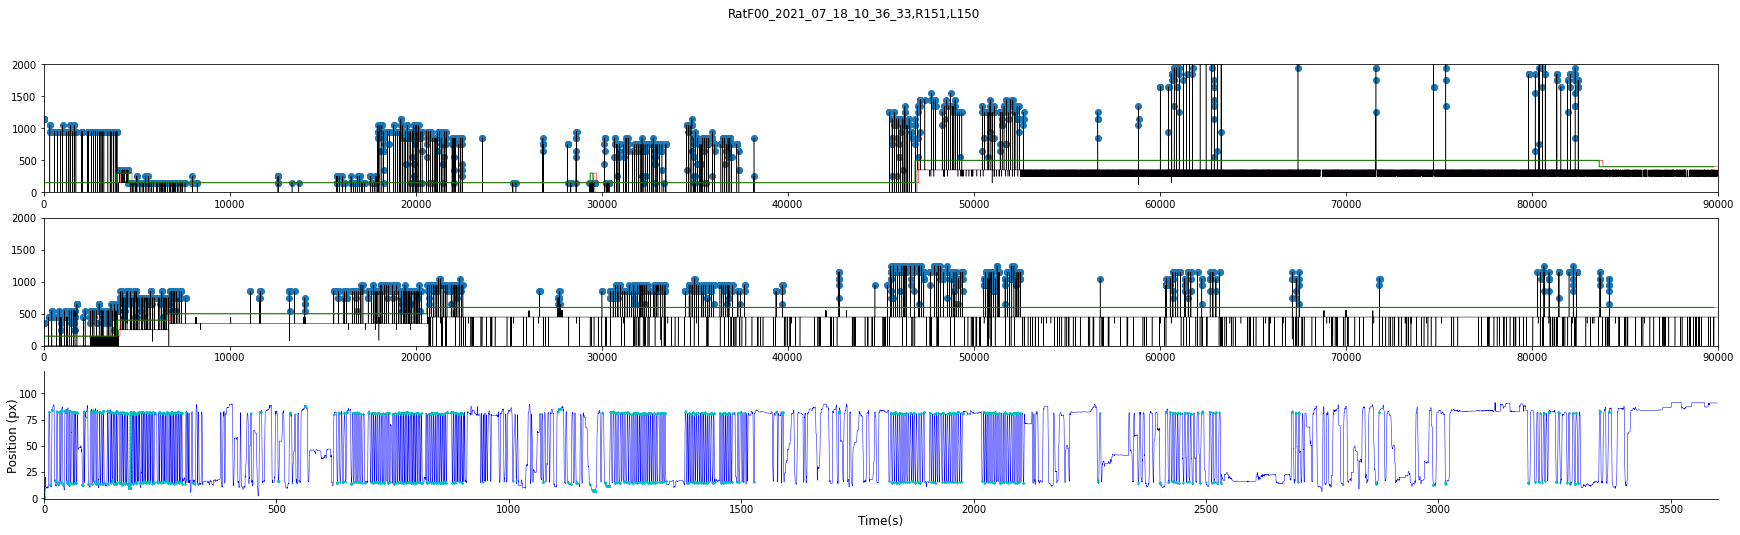

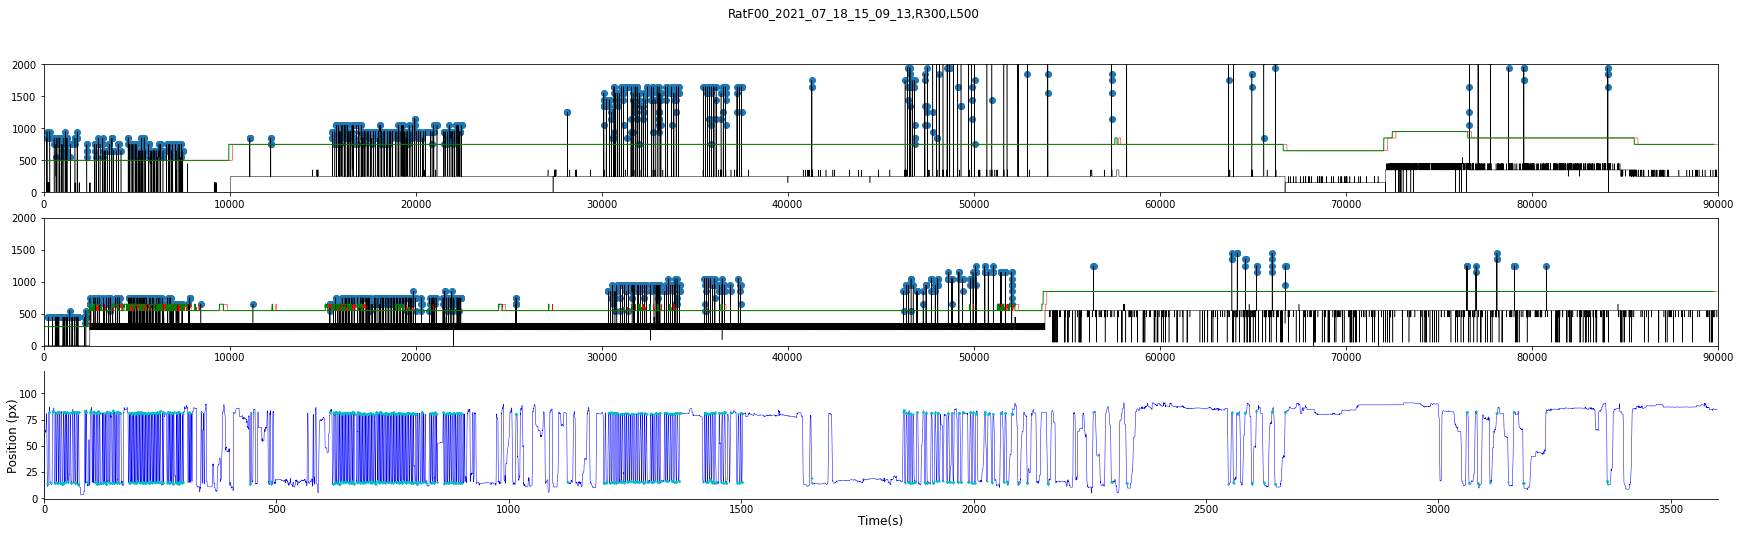

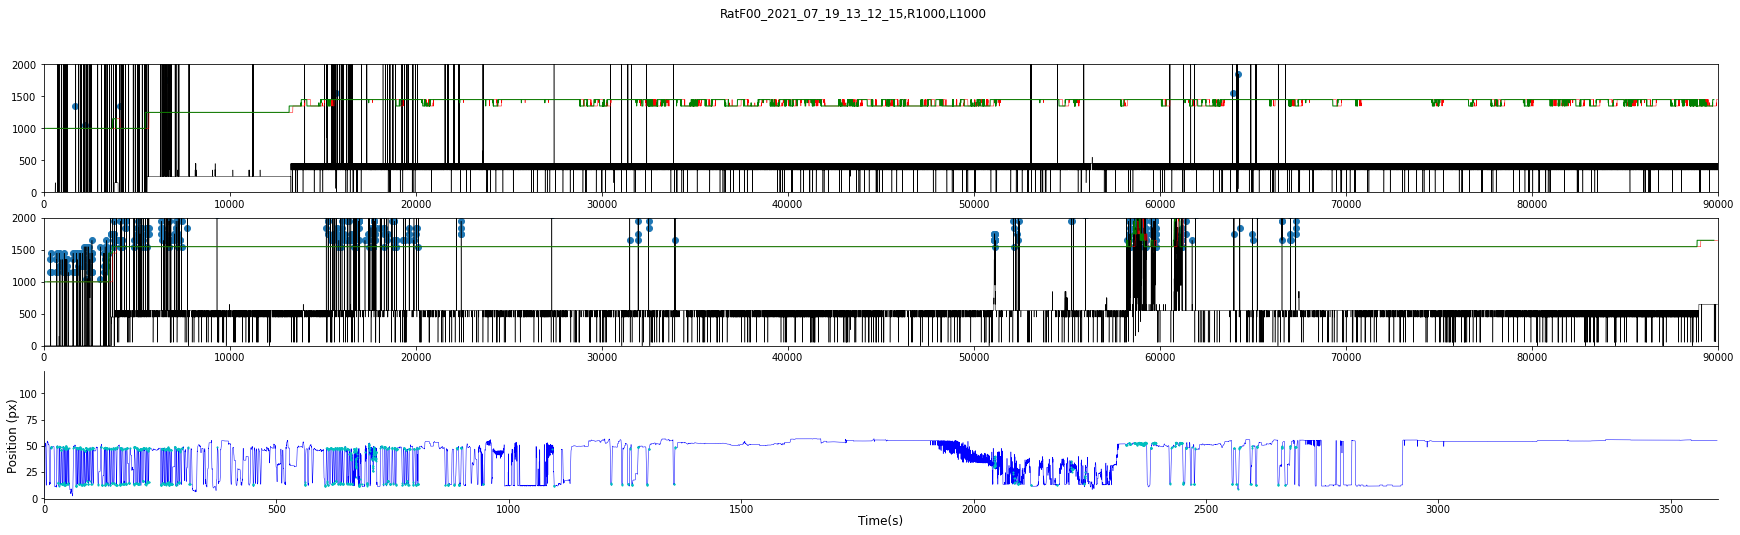

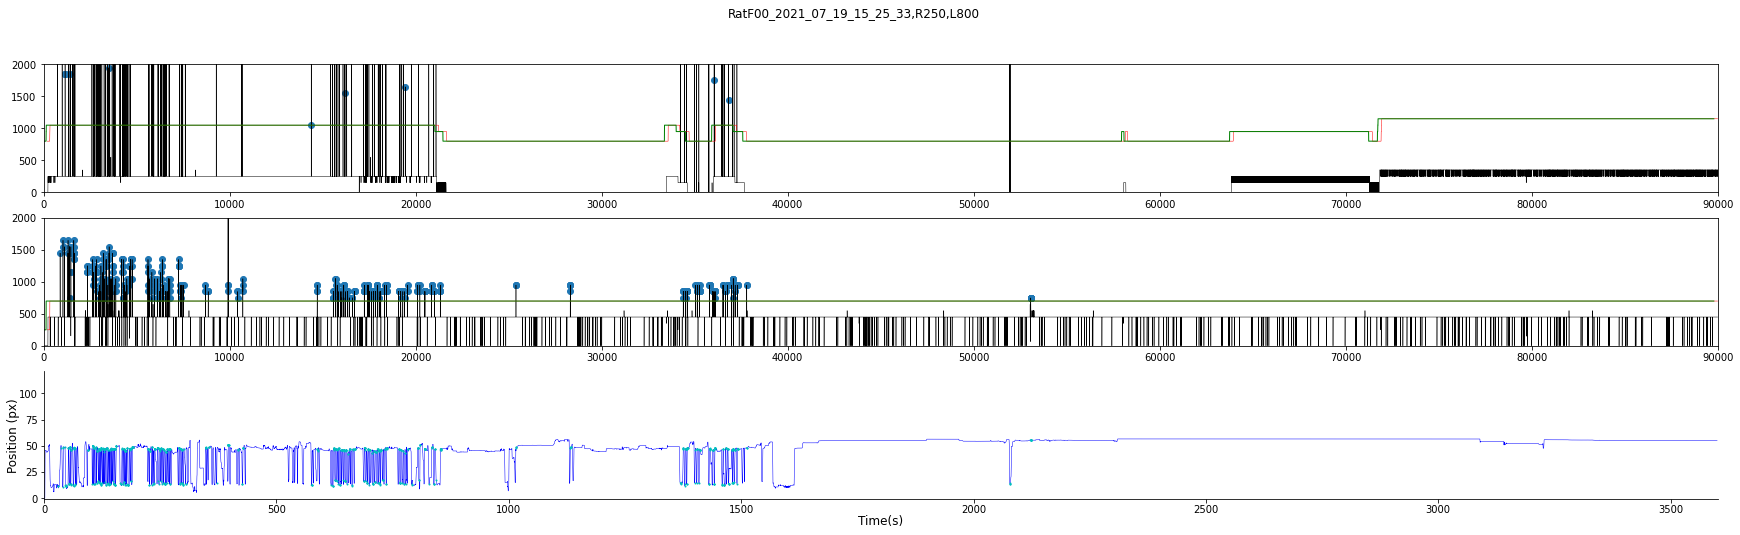

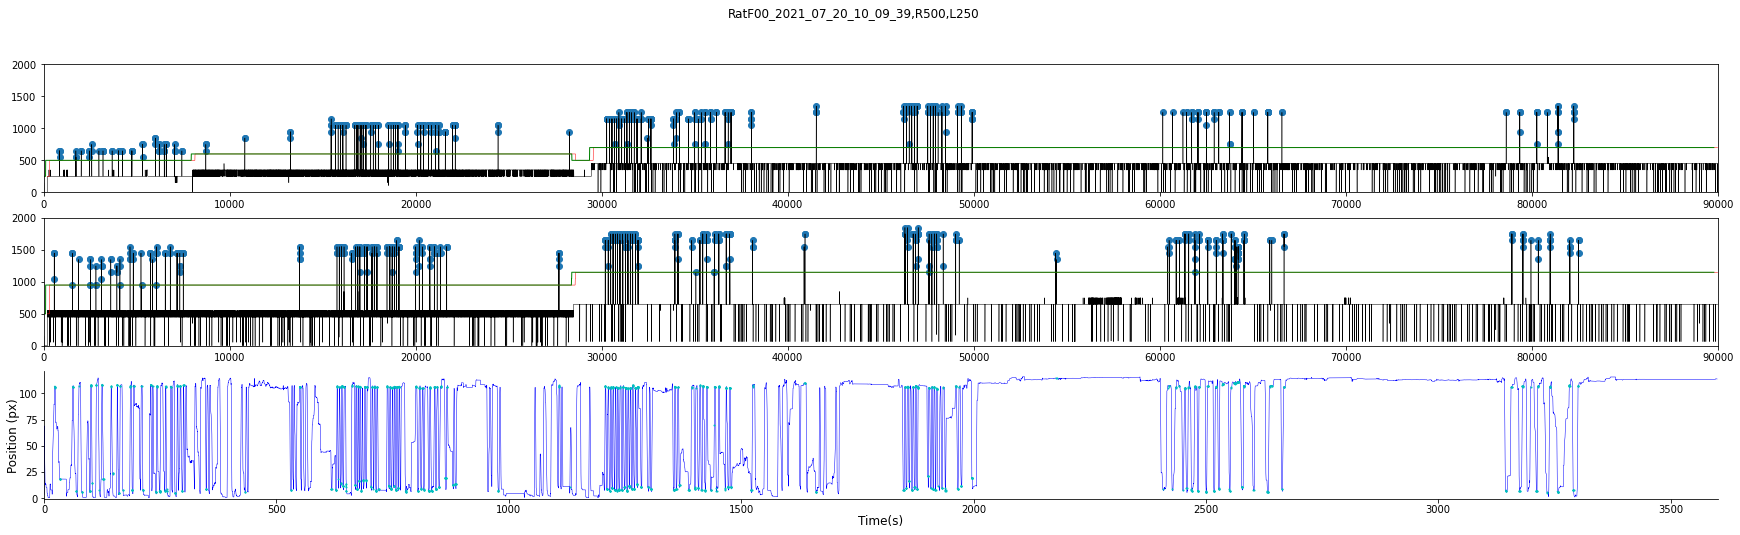

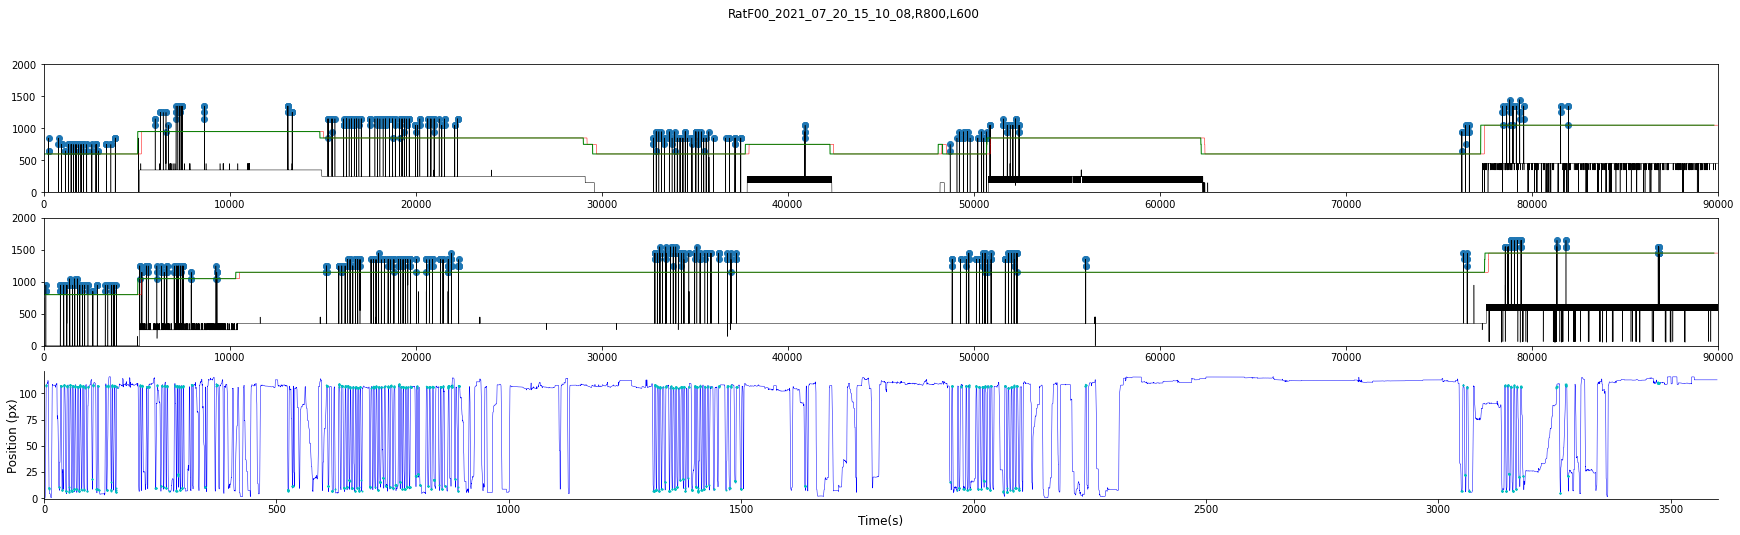

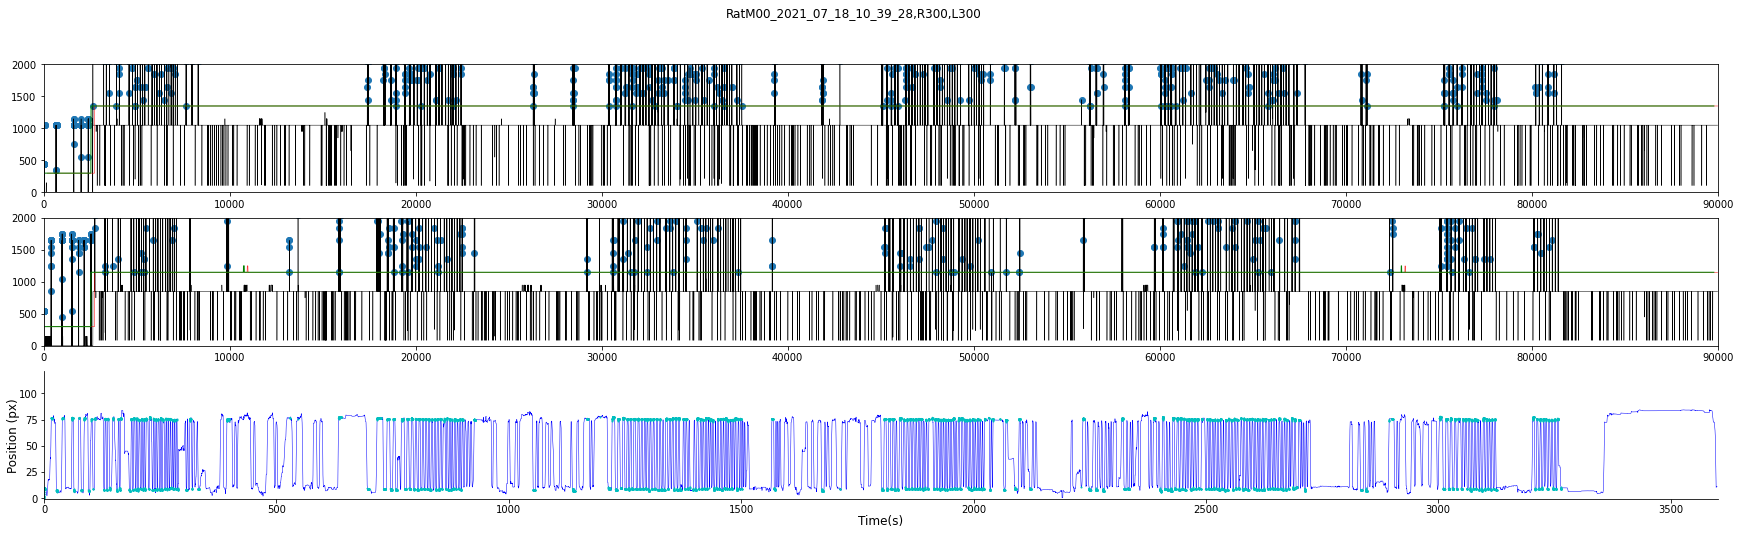

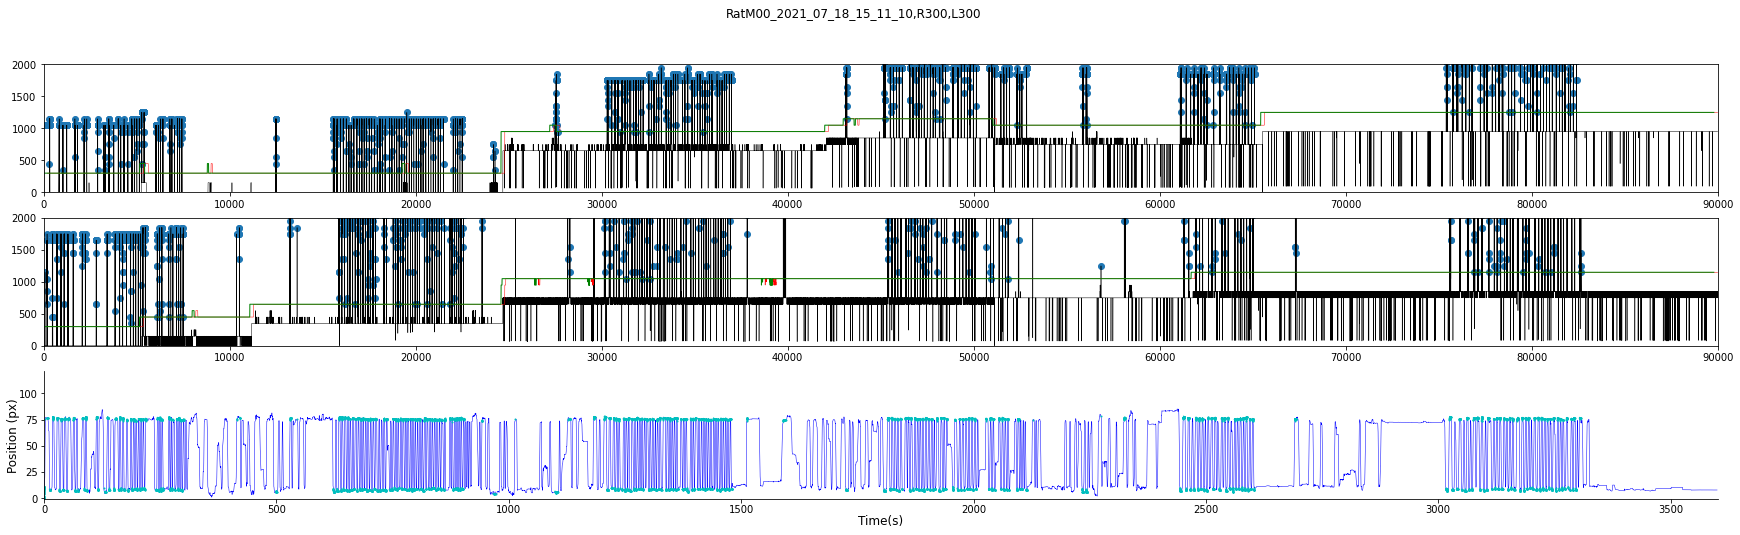

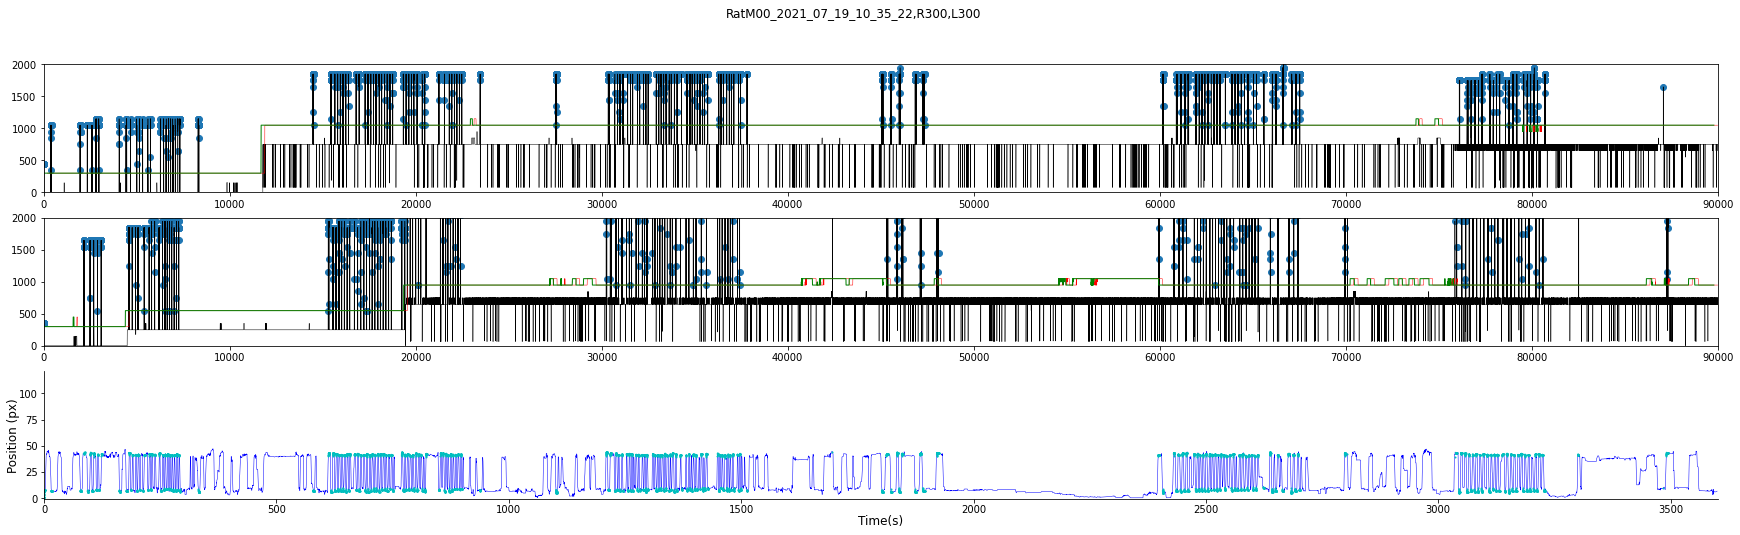

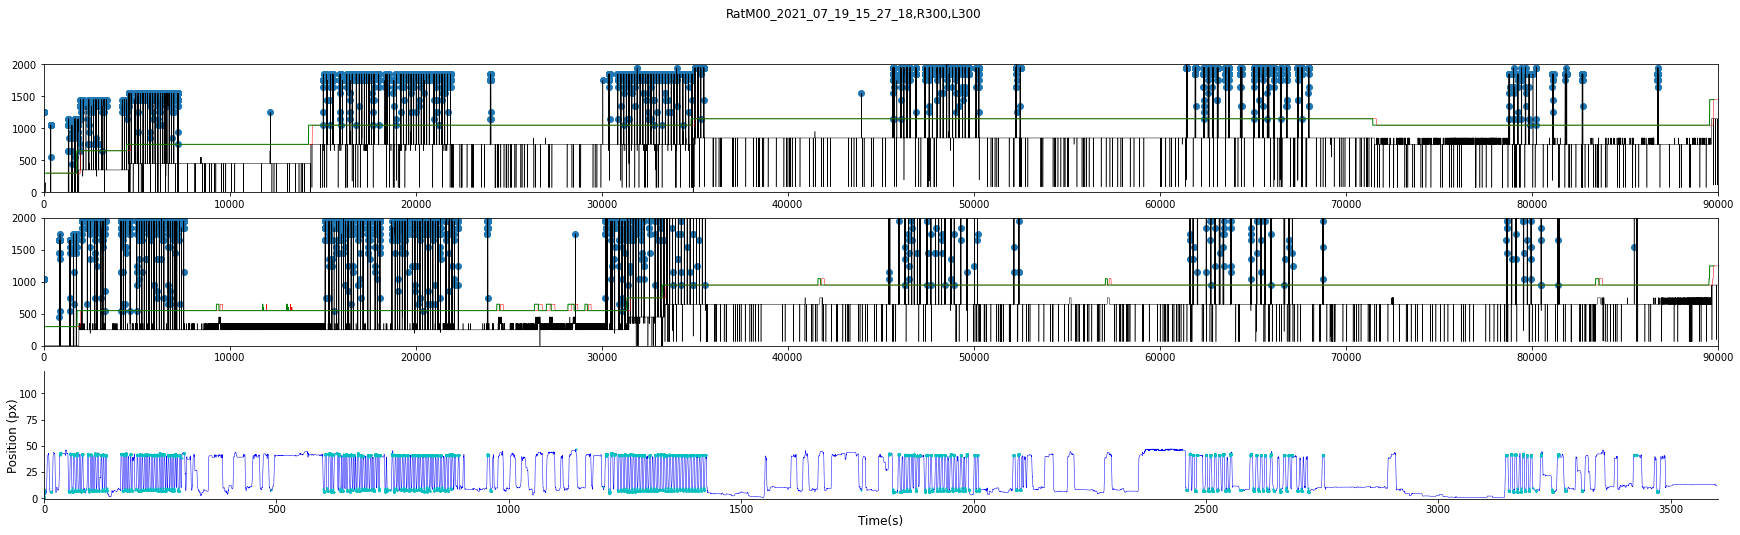

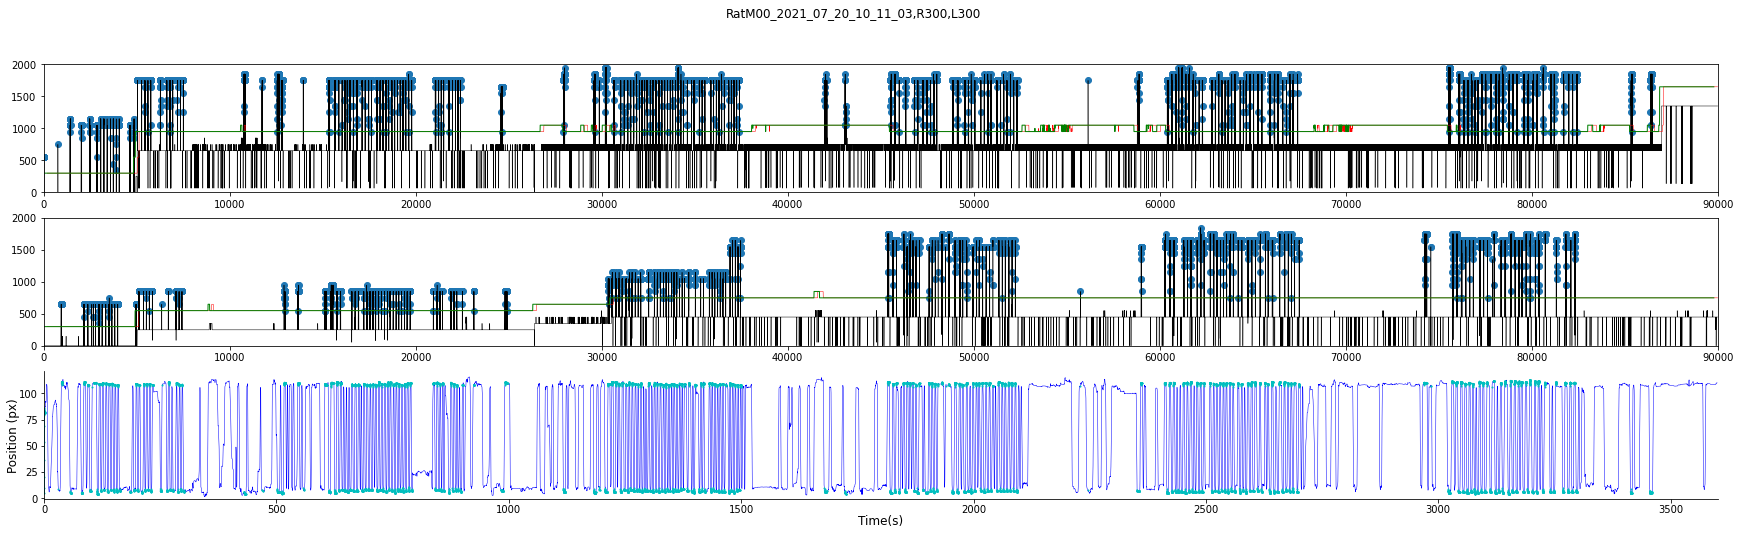

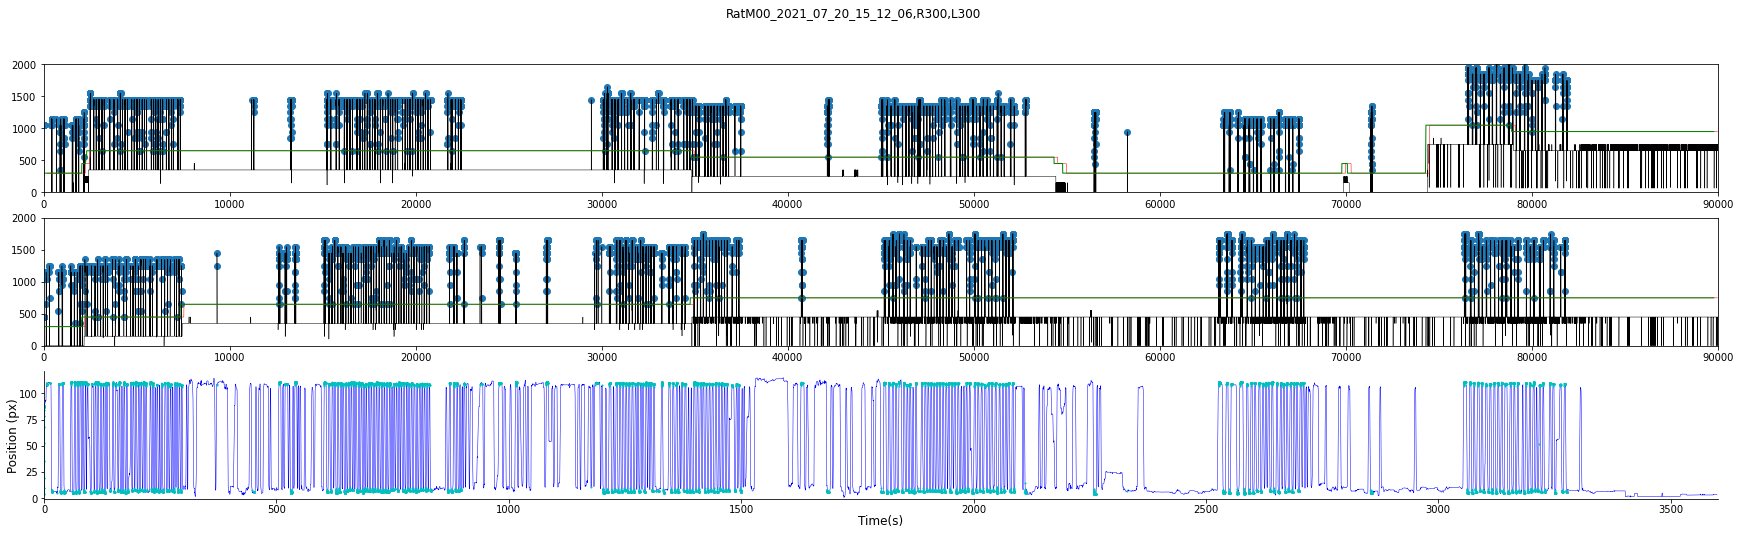

In [55]:
def movinmedian(interval, window_size):
    if window_size != 0: window =int(window_size)
    else: print("Error: Window size == 0")
    val = pd.Series(interval)
    return val.rolling(window).median()

def reversemovinmedian(interval, window_size):
    if window_size != 0: window =int(window_size)
    else: print("Error: Window size == 0")
    val = pd.Series(interval[::-1])
    return list(reversed(val.rolling(window).median()))



for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]): 
        lickthresholdLeft = params[animal, session]["lickthresholdLeft"] if params[animal, session]["lickthresholdLeft"] != None else 300 #Before, the default value (300) was used and modified manually during the analysis. Now we can directly read if/what value that has been modofied directly in LV.
        lickthresholdRight = params[animal, session]["lickthresholdRight"] if params[animal, session]["lickthresholdRight"] != None else 300
        if params[animal, session]["lickthresholdLeft"] == None: params[animal, session]["lickthresholdLeft"] = 300
        if params[animal, session]["lickthresholdRight"] == None:  params[animal, session]["lickthresholdRight"] = 300
        bbb= []
        ccc= []
        window = 200
        for val, avgval in zip(rawLickLeft2X[animal, session], movinavg(rawLickLeft2X[animal, session], window)):
            if val <= avgval-lickthresholdLeft: bbb.append(avgval)
            else: bbb.append(val)

        for val1, avgval1 in zip(rawLickRight2X[animal, session], movinavg(rawLickRight2X[animal, session], window)):
            if val1 <= avgval1-lickthresholdRight: ccc.append(avgval1)
            else: ccc.append(val1)

        aaa = range(0, len(rawLickLeft2X[animal, session]))
        lick = plt.figure(figsize=(30, 8))
        lick.suptitle("{0},R{1},L{2}".format(session,lickthresholdRight,lickthresholdLeft))
        L = lick.add_subplot(3, 1, 1)
        R = lick.add_subplot(3, 1, 2)
        P = lick.add_subplot(3, 1, 3)
        L.set_ylim(0, 2000)
        R.set_ylim(0, 2000)
        L.set_xlim(0, 90000)
        R.set_xlim(0, 90000)

        rawLickLeft3X[animal, session] = [k if i -j >= lickthresholdLeft else 0 for i, j, k in zip(rawLickLeft2X[animal, session], reversemovinmedian(rawLickLeft2X[animal, session], window), rawPositionX[animal, session])]
        rawLickRight3X[animal, session] = [k if i-j >= lickthresholdRight else 0 for i, j, k in zip(rawLickRight2X[animal, session], reversemovinmedian(rawLickRight2X[animal, session], window), rawPositionX[animal, session])]


        P = plot_BASEtrajectory(rawTime[animal, session],rawPositionX[animal, session], rawLickLeft3X[animal, session], rawLickRight3X[animal, session], [0, read_params("sessionDuration"), 1],[0,120,1],  color = ["b", "c"], marker = ["", "o", 1], linewidth = [0.5], xyLabels=["Position (px)", "Time(s)"])


        L.plot(rawLickLeft2X[animal, session], lw=0.5, c='k')
        L.plot(movinmedian(rawLickLeft2X[animal, session], window)+lickthresholdLeft, lw=0.5, c='r')
        L.plot([i + lickthresholdLeft for i in reversemovinmedian(rawLickLeft2X[animal, session], window)], lw=1, c='g')

        R.plot(rawLickRight2X[animal, session], lw=0.5, c='k')
        R.plot(movinmedian(rawLickRight2X[animal, session], window)+lickthresholdRight, lw=0.5, c='r')
        R.plot([i + lickthresholdRight for i in reversemovinmedian(rawLickRight2X[animal, session], window)], lw=1, c='g')


        L.scatter(aaa, [i if i-j >= params[animal, session]["lickthresholdLeft"]  else None for i, j in zip(rawLickLeft2X[animal, session],  reversemovinmedian(rawLickLeft2X[animal, session],  window))])
        R.scatter(aaa, [i if i-j >= params[animal, session]["lickthresholdRight"] else None for i, j in zip(rawLickRight2X[animal, session], reversemovinmedian(rawLickRight2X[animal, session], window))])


In [40]:
def movinmedian(interval, window_size):
    if window_size != 0: window =int(window_size)
    else: print("Error: Window size == 0")
    val = pd.Series(interval)
    return val.rolling(window).median()

def reversemovinmedian(interval, window_size):
    if window_size != 0: window =int(window_size)
    else: print("Error: Window size == 0")
    val = pd.Series(interval[::-1])
    return list(reversed(val.rolling(window).median()))

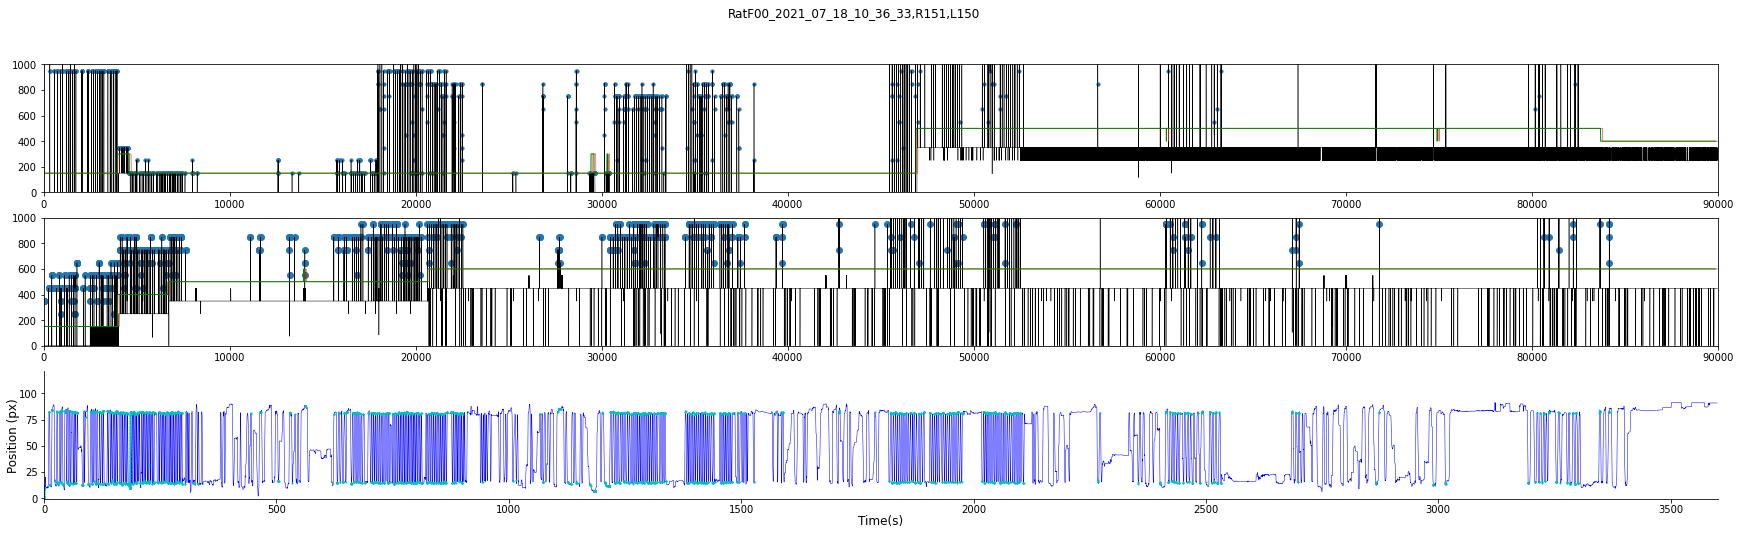

In [54]:
animal, session = 'RatF00' , 'RatF00_2021_07_18_10_36_33'

params[animal, session]["lickthresholdLeft"] = 150
params[animal, session]["lickthresholdRight"] = 151
bbb= []
ccc= []
window = 100
for val, avgval in zip(rawLickLeft2X[animal, session], movinavg(rawLickLeft2X[animal, session], window)):
    if val <= avgval-lickthresholdLeft: bbb.append(avgval)
    else: bbb.append(val)

for val1, avgval1 in zip(rawLickRight2X[animal, session], movinavg(rawLickRight2X[animal, session], window)):
    if val1 <= avgval1-lickthresholdRight: ccc.append(avgval1)
    else: ccc.append(val1)

aaa = range(0, len(rawLickLeft2X[animal, session]))
lick = plt.figure(figsize=(30, 8))
lick.suptitle("{0},R{1},L{2}".format(session,lickthresholdRight,lickthresholdLeft))
L = lick.add_subplot(3, 1, 1)
R = lick.add_subplot(3, 1, 2)
P = lick.add_subplot(3, 1, 3)
L.set_ylim(0, 1000)
R.set_ylim(0, 1000)
L.set_xlim(0, 90000)
R.set_xlim(0, 90000)

rawLickLeft3X[animal, session] = [k if i -j >= lickthresholdLeft else 0 for i, j, k in zip(rawLickLeft2X[animal, session], reversemovinmedian(rawLickLeft2X[animal, session], window), rawPositionX[animal, session])]
rawLickRight3X[animal, session] = [k if i-j >= lickthresholdRight else 0 for i, j, k in zip(rawLickRight2X[animal, session], reversemovinmedian(rawLickRight2X[animal, session], window), rawPositionX[animal, session])]


rawLickLeft2X[animal, session][0:4000] = [l+100 if l!=0 else 0 for l in rawLickLeft2X[animal, session][0:4000]]
L.plot(rawLickLeft2X[animal, session], lw=0.5, c='k')
L.plot(movinmedian(rawLickLeft2X[animal, session], window)+lickthresholdLeft, lw=0.5, c='r')
L.plot([i + lickthresholdLeft for i in reversemovinmedian(rawLickLeft2X[animal, session], window)], lw=1, c='g')

R.plot(rawLickRight2X[animal, session], lw=0.5, c='k')
R.plot(movinmedian(rawLickRight2X[animal, session], window)+lickthresholdRight, lw=0.5, c='r')
R.plot([i + lickthresholdRight for i in reversemovinmedian(rawLickRight2X[animal, session], window)], lw=1, c='g')


L.scatter(aaa, [i if i-j >= params[animal, session]["lickthresholdLeft"]  else None for i, j in zip(rawLickLeft2X[animal, session],  reversemovinmedian(rawLickLeft2X[animal, session],  window))], s=10)
R.scatter(aaa, [i if i-j >= params[animal, session]["lickthresholdRight"] else None for i, j in zip(rawLickRight2X[animal, session], reversemovinmedian(rawLickRight2X[animal, session], window))])


P = plot_BASEtrajectory(rawTime[animal, session],rawPositionX[animal, session], rawLickLeft3X[animal, session], rawLickRight3X[animal, session], [0, 3600, 1],[0,120,1],  color = ["b", "c"], marker = ["", "o", 1], linewidth = [0.5], xyLabels=["Position (px)", "Time(s)"])


# Create rat markers
### Define a marker (male, female) and a color for each rat (plots are prettier)

In [42]:
rat_markers={}
rat_markers[animal] = {}
#OLD palette = ['r', 'm', 'y', 'c', 'r', 'm', 'y', 'c']
palette = ['darkred', 'indianred', 'orangered', 'tomato', 'darkgreen', 'forestgreen', 'limegreen', 'chartreuse']
index = 0
for animal in animalList:
    # if the animal is F use Female symbol and 1 color per F rat
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[palette[index], "$\u2640$"]
        index+=1
    elif fnmatch.fnmatch(animal, 'RatM*'):
        #same for males
        rat_markers[animal]=[palette[index], "$\u2642$"]
        index+=1  
        #if rat is not F or M (Rat000) use black and ? 
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[palette[index], "$\u2426$"]
        index+=1 
    else:
        print("error, bypass? Y/N")
        answer = input()
        if answer== 'Y':
            rat_markers[animal]= ['k',"$\u2426$"] 
        else:
            print("do nothing")

# BASE TRAJECTORY
### This first part is about plotting the trajectory+licks of the animals along the X axis.

In [43]:
# This function plots the base trajectory of the rat. Parameters are time : time data, position : X position data, lickL/R, lick data, maxminstep for x and y axis, color and marker of the plot, width of the axis, and x y labels
def plot_BASEtrajectory(time, position, lickLeft, lickRight, maxminstep, maxminstep2, color = [], marker = [], linewidth = [], xyLabels=["N","Bins"]):   
        #select data that we want to plot
        plt.plot(time, position, color=color[0], marker=marker[0], linewidth = linewidth[0])#easy time againt position of the animal
        plt.plot(time, [None if x == 0 else x for x in lickLeft], color=color[1], marker=marker[1], markersize = marker[2])#lick data, plot position in which the animal licked, NoLick = we don't care so None
        plt.plot(time, [None if x == 0 else x for x in lickRight], color=color[1], marker=marker[1], markersize = marker[2])
        #configure plot
        ax0 = plt.gca()
        #configure ax xy span
        ax0.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
        ax0.set_ylim(maxminstep2[0]-maxminstep2[2],maxminstep2[1]+maxminstep2[2])
        #configure xy style
        ax0.set_xlabel(xyLabels[1],fontsize=12,labelpad=0)
        ax0.set_ylabel(xyLabels[0],fontsize=12,labelpad=-1)
        ax0.xaxis.set_ticks_position('bottom')
        ax0.yaxis.set_ticks_position('left')
        ax0.get_xaxis().set_tick_params(direction='out',pad=2)
        ax0.get_yaxis().set_tick_params(direction='out',pad=2)
        #remove unnecessary axes
        ax0.spines['top'].set_color("none")
        ax0.spines['right'].set_color("none")
        return ax0

In [44]:
# Function to compute start of run and end of run boundaries
# animals lick in the extremities, so they spend more time there, so probability of them being there is more important than the probability of being in the middle of the apparatus. we compute the two average positions of these resting points. We defined a run as the trajectory of the animal between the resting points. So we have to find these resting points. In later stages of the experiments the start/end of runs is defined based on the speed of the animals. 
# function params : data is X position array for the session that we analyse, height = parameter to define a limit to the probability of detecting a place as significantly more probable than another.
#We use a KDE (Kernel Density Estimate) to find said places. See testhitopeak.ipynb 2nd method for histogram. histogram is coded in next cell between """ """, but does not work on linux
def extract_boundaries(data, animal, session, height = None):
    kde = stats.gaussian_kde(data)
    #compute KDE = get the position probability curve and compute peaks of the curve
    peak_pos, peak_height = [], []
    nb_samples = 120 #played a bit with the values, this works (number of data bins, we chose 1 per cm, also tested 10 bins per cm)
    samples = np.linspace(0, 120, nb_samples)
    probs = kde.evaluate(samples)
    maxima_index = find_peaks(probs, height) 
    peak_pos = maxima_index[0]
    peak_height = maxima_index[1]["peak_heights"]
    #print("values", peak_pos, peak_height)
    # if there is more than two peaks (e.g. an animal decides to stay in the middle of the treadmill), only keep the two biggest peaks (should be the extremities) and remove the extra peak/s if there is one or more
    
    peak_posLeft, peak_heightLeft, peak_posRight, peak_heightRight = [], [], [], []
    for i, j in zip(peak_pos, peak_height):
        if i < params[animal, session]['treadmillDist']/2:
            peak_posLeft.append(i)
            peak_heightLeft.append(j)
        if i > params[animal, session]['treadmillDist']/2:
            peak_posRight.append(i)
            peak_heightRight.append(j)
    leftBoundaryPeak = peak_posLeft[np.argmax(peak_heightLeft)]
    rightBoundaryPeak = peak_posRight[np.argmax(peak_heightRight)]
    print("computing bounds ok", animal, leftBoundaryPeak, rightBoundaryPeak) 
    return leftBoundaryPeak, rightBoundaryPeak, kde

# this function plots the peak that we just extracted
def plot_peak(data, animal, session, leftBoundaryPeak, rightBoundaryPeak, kde, maxminstep, maxminstep2, marker = [], xyLabels=["N","Bins"]):
    #fig, ax = plt.subplots(figsize=(3,6))
    bins = np.arange(120)
    xx = np.linspace(0, 120, 120)
    xline1 = [leftBoundaryPeak, leftBoundaryPeak]
    xline2 = [rightBoundaryPeak, rightBoundaryPeak]
    yline = [0, 0.01]
    
    ax7 = plt.gca()
    if platform.system()== 'Darwin':
        ax7.hist(data, normed=True, bins=bins, alpha=0.3, orientation='horizontal') #bugged on linux, working on mac
    #plot kde + boundaries
    ax7.plot(kde(xx), xx, color = 'r')
    ax7.plot(yline, xline1, ":", color='k')
    ax7.plot(yline, xline2, ":", color='k')
    ax7.plot(yline, [xline1[0]+border, xline1[0]+border], ":", color='k', alpha = 0.5)
    ax7.plot(yline, [xline2[0]-border, xline2[0]-border], ":", color='k', alpha = 0.5)
    #configure plot
    ax7.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
    ax7.set_ylim(maxminstep2[0]-maxminstep2[2],maxminstep2[1]+maxminstep2[2])
    ax7.set_xlabel(xyLabels[1],fontsize=12,labelpad=0)
    ax7.set_ylabel(xyLabels[0],fontsize=12,labelpad=-1)
    ax7.spines['top'].set_color("none")
    ax7.spines['left'].set_color("none")
    ax7.spines['right'].set_color("none")
    ax7.yaxis.set_ticks_position('left')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.get_xaxis().set_tick_params(direction='out',pad=2)
    ax7.get_yaxis().set_tick_params(direction='out',pad=2)
    ax7.axes.get_yaxis().set_visible(False)
    return ax7

computing bounds ok RatF00 16 81
plotting RatF00
computing bounds ok RatF00 15 83
plotting RatF00
computing bounds ok RatF00 8 109
plotting RatF00
computing bounds ok RatF00 13 54
plotting RatF00
computing bounds ok RatF00 7 111
plotting RatF00
computing bounds ok RatF00 13 55
plotting RatF00
computing bounds ok RatM00 10 74
plotting RatM00
computing bounds ok RatM00 8 40
plotting RatM00
computing bounds ok RatM00 9 41
plotting RatM00
computing bounds ok RatM00 9 74
plotting RatM00
computing bounds ok RatM00 9 107
plotting RatM00
computing bounds ok RatM00 8 107
plotting RatM00


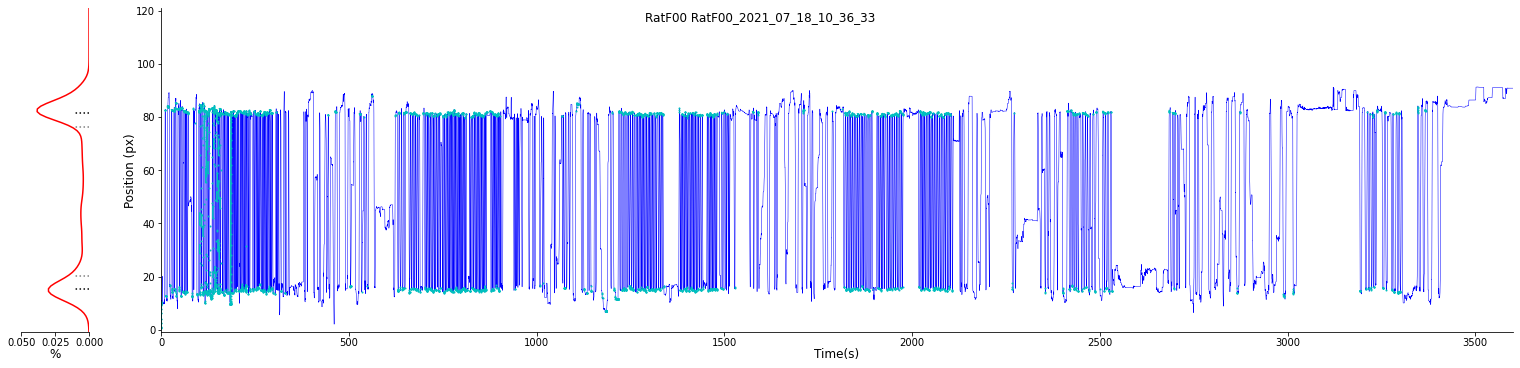

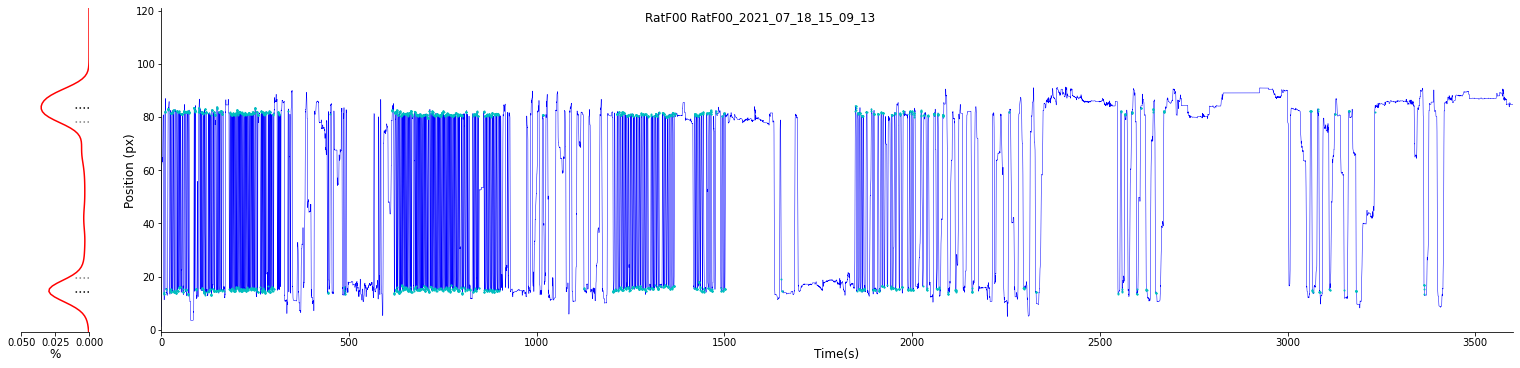

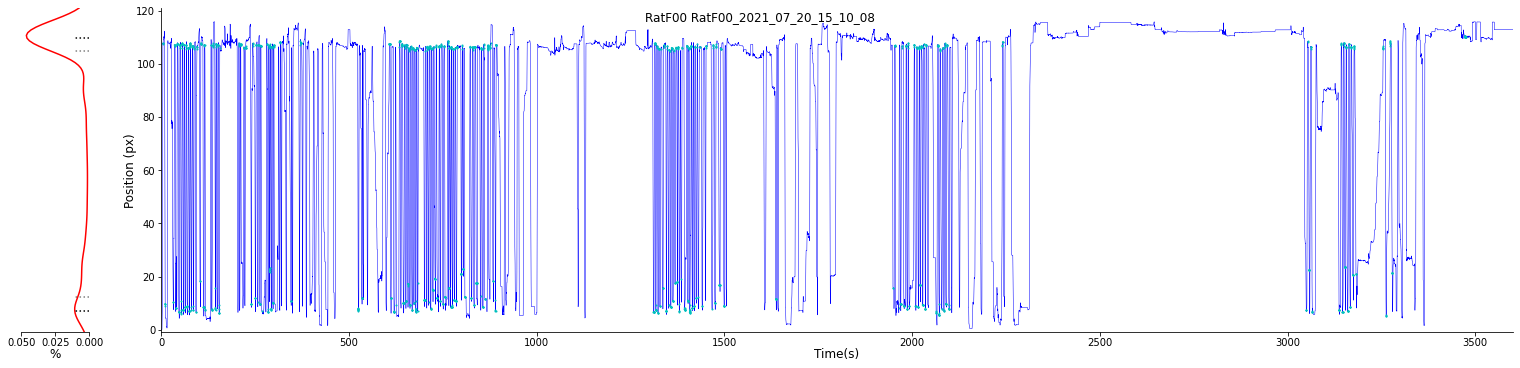

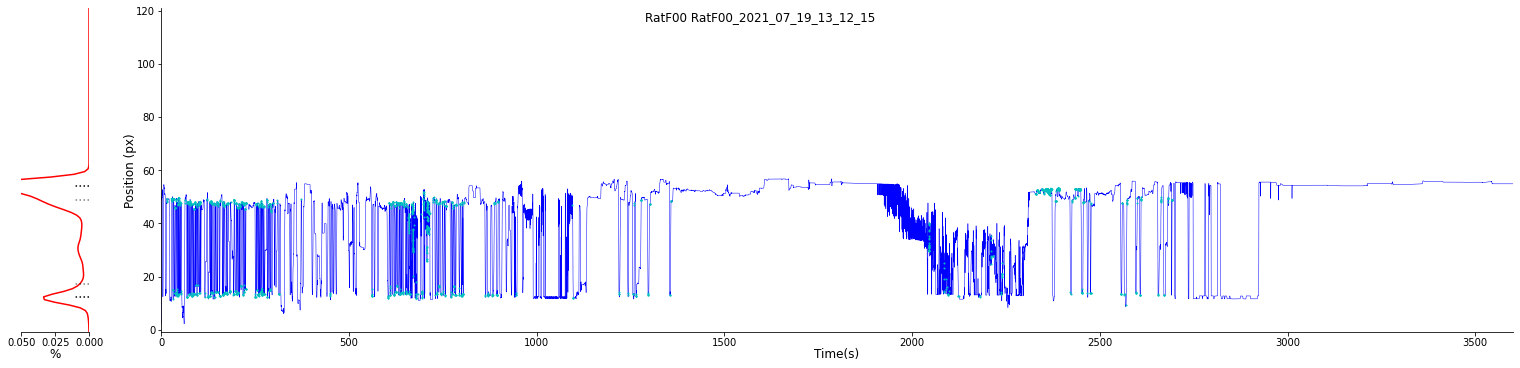

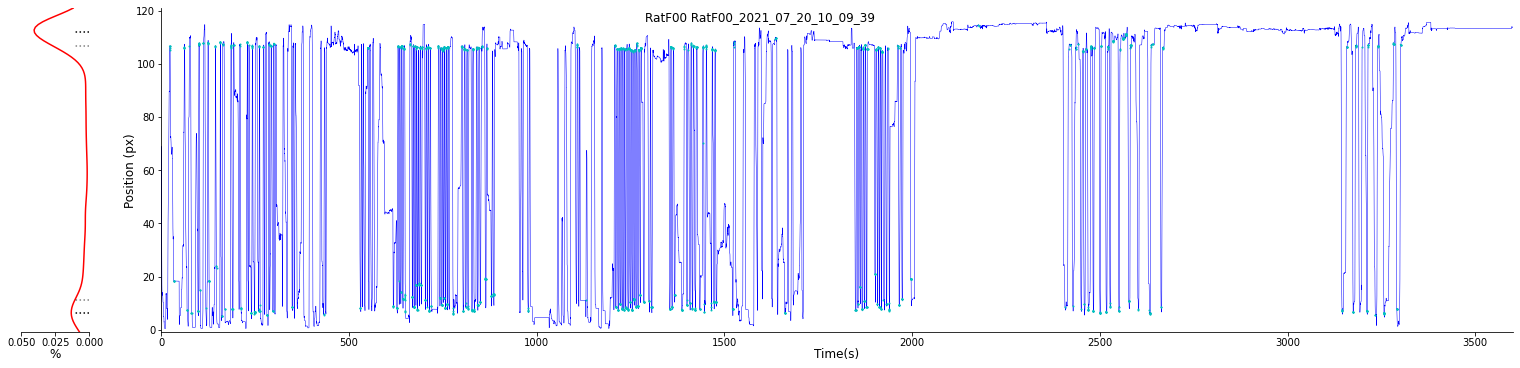

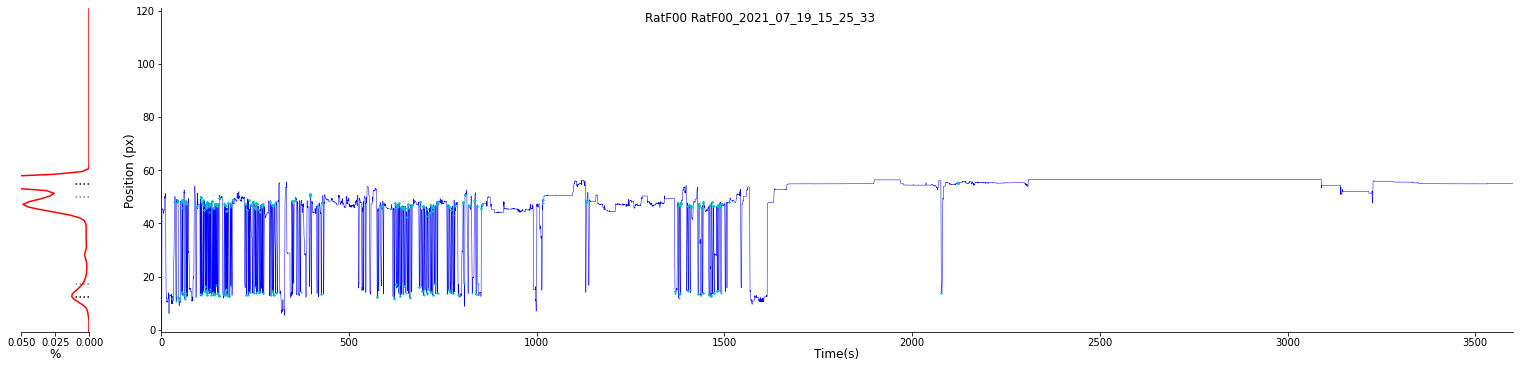

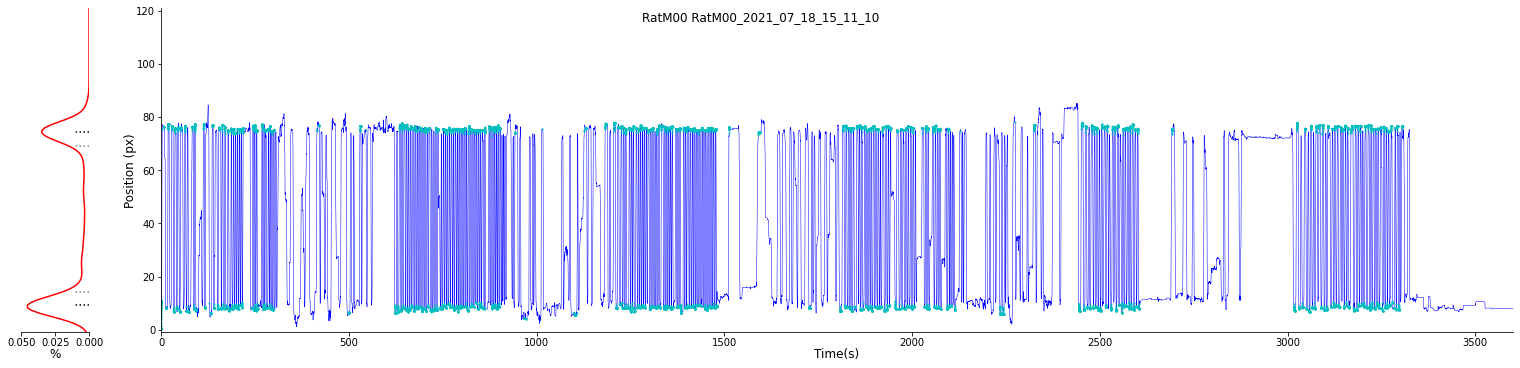

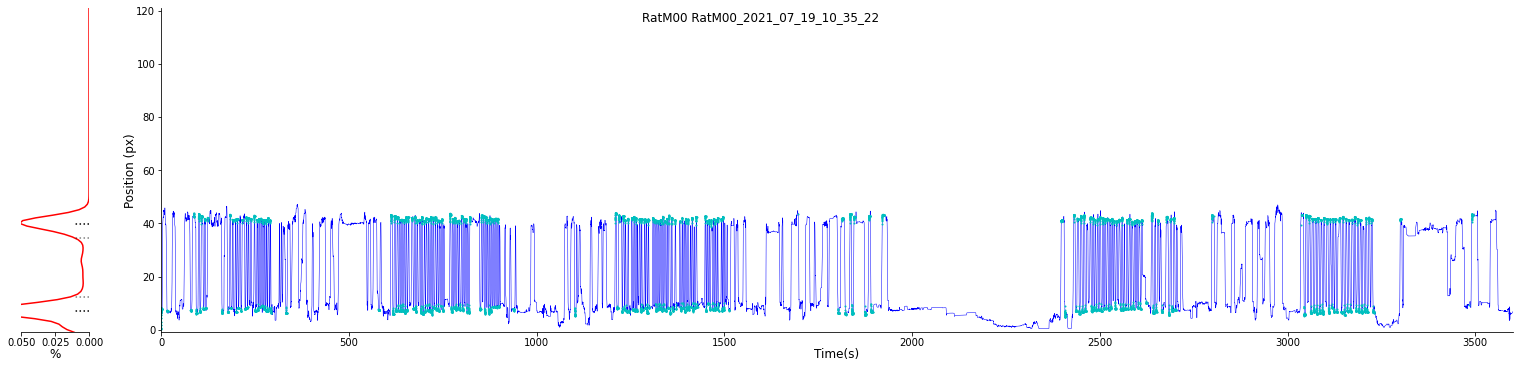

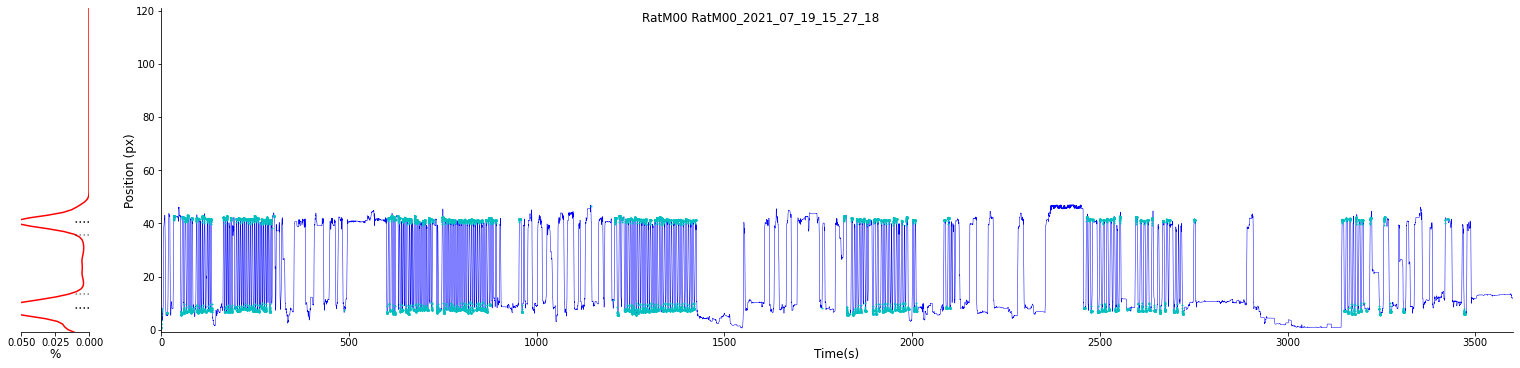

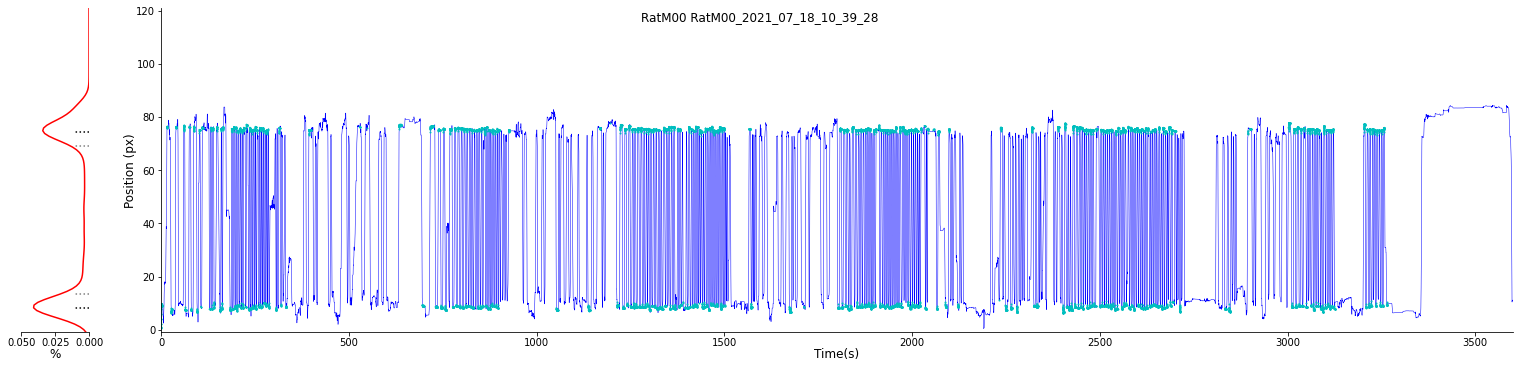

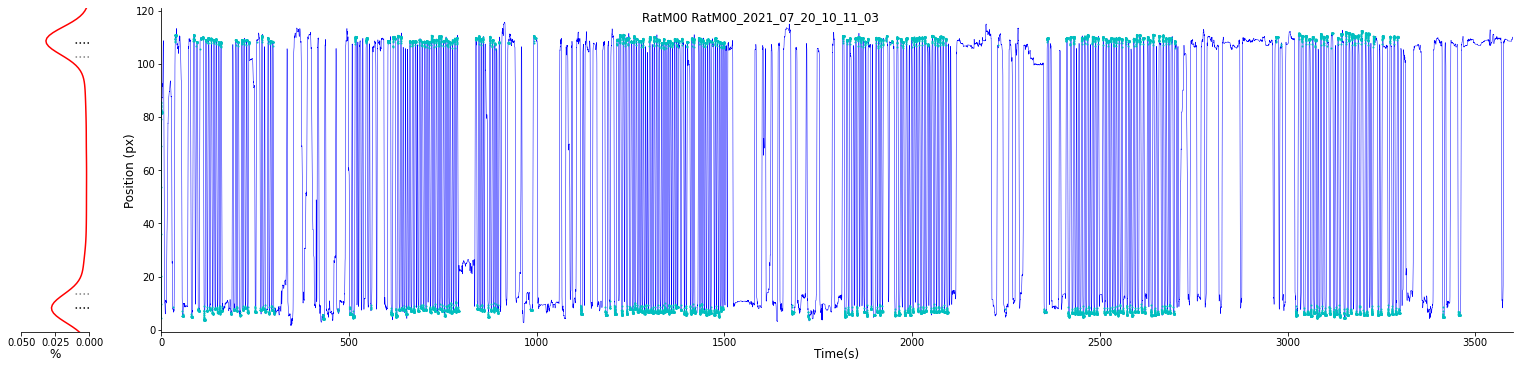

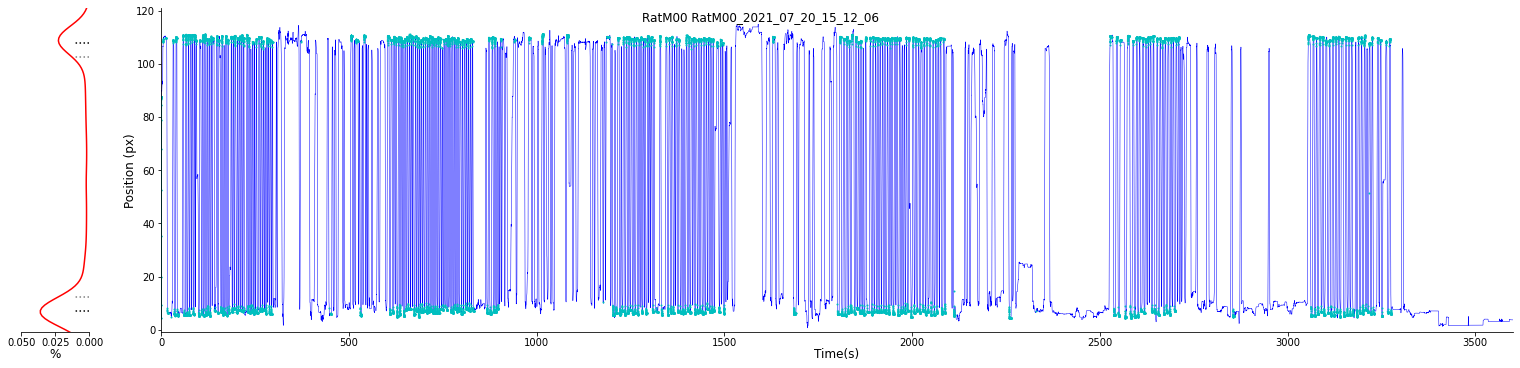

In [45]:
#Use previously defined functions to compute the boundaries and store them in params. Result is saved as pickle. 
if redoAll_Override is None: redoBoundKDE = False #redo computation YES/NO
leftBoundaryPeak = {}
rightBoundaryPeak = {}
kde = {}
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList:
        #Avoid recomputing KDE (quite long) so fetch pickle file if already there
        picklePath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"boundaries.p"
        if os.path.exists(picklePath) and (not redoBoundKDE):
            params[animal, session]["boundaries"] = get_from_pickle(animal, session, name="boundaries.p")
        else:
            border = 5 #define arbitrary border
            leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session]= extract_boundaries(rawPositionX[animal, session], animal, session, height = 0.001)
            params[animal, session]["boundaries"] = [rightBoundaryPeak[animal, session] - border, leftBoundaryPeak[animal, session] + border]
            #params[animal, session]["boundaries"] = [800, 200]
            save_as_pickle(params[animal, session]["boundaries"], animal, session, "boundaries.p")

#problem leftBoundaryPEak, rightBoundaryPeak and kde are not created if we read the information from params
        print("plotting", animal)
        fig = plt.figure(constrained_layout=True, figsize=(21,5))
        fig.suptitle(animal + " " + session)
        widths = [1, 20]
        heights = [5]
        rows = 1
        cols = 2

        spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
        index =0
        for row in range(rows):
            for col in range(cols):
                ax = fig.add_subplot(spec[row, col])
                if index == 0:
                    plot_peak(rawPositionX[animal, session], animal, session, leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session],[0.05, 0, 0],[0,120,0],  marker = [""], xyLabels=["Position (cm)", "%"])
                    index+=1
                elif index == 1:
                    plot_BASEtrajectory(rawTime[animal, session],rawPositionX[animal, session], rawLickLeft3X[animal, session], rawLickRight3X[animal, session], [0, read_params("sessionDuration"), 1],[0,120,1],  color = ["b", "c"], marker = ["", "o", 1], linewidth = [0.5], xyLabels=["Position (px)", "Time(s)"])
                    index+=1

def movinmedian(interval, window_size):
    if window_size != 0: window =int(window_size)
    else: print("Error: Window size == 0")
    val = pd.Series(interval)
    return val.rolling(window).median()


###thisone
rawLickLeft3X = {}
rawLickRight3X = {}
rawLickLeft3X[animal, session] = []
rawLickRight3X[animal, session] = []
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]): 
        lickthresholdLeft = params[animal, session]["lickthresholdLeft"] if params[animal, session]["lickthresholdLeft"] != None else 300 #Before, the default value (300) was used and modified manually during the analysis. Now we can directly read if/what value that has been modofied directly in LV.
        lickthresholdRight = params[animal, session]["lickthresholdRight"] if params[animal, session]["lickthresholdRight"] != None else 300
        if params[animal, session]["lickthresholdLeft"] == None: params[animal, session]["lickthresholdLeft"] = 300
        if params[animal, session]["lickthresholdRight"] == None:  params[animal, session]["lickthresholdRight"] = 300
        bbb= []
        ccc= []
        window = 200
        for val, avgval in zip(rawLickLeft2X[animal, session], movinavg(rawLickLeft2X[animal, session], window)):
            #if val <= avgval: val = avgval + lickthresholdLeft
            if val <= avgval-lickthresholdLeft: bbb.append(avgval)
            else: bbb.append(val)

        for val1, avgval1 in zip(rawLickRight2X[animal, session], movinavg(rawLickRight2X[animal, session], window)):
            #if val <= avgval: val = avgval + lickthresholdLeft
            if val1 <= avgval1-lickthresholdRight: ccc.append(avgval1)
            else: ccc.append(val1)

        
        #rawLickLeft3X[animal, session] = [k if i >= j+lickthresholdLeft/2 else 0 for i, j, k in zip(bbb, movinavg(bbb, 200), rawPositionX[animal, session])]
        #rawLickRight3X[animal, session] = [k if i >= j+lickthresholdRight/2 else 0 for i, j, k in zip(ccc, movinavg(ccc, 200), rawPositionX[animal, session])]

        aaa = range(0, len(rawLickLeft2X[animal, session]))
        lick = plt.figure(figsize=(30, 7))
        lick.suptitle(session)
        L = lick.add_subplot(2, 1, 1)
        R = lick.add_subplot(2, 1, 2)
        L.set_ylim(0, 2000)
        R.set_ylim(0, 2000)
        Ldata = [i-j if i-j>0 else 0 for i, j in zip(rawLickLeft2X[animal, session], movinmedian(rawLickLeft2X[animal, session], window))]
        Ldata = [i if i<=1500 else 1500 for i in Ldata]
        #L.plot([i-j if i-j>0 else 0 for i, j in zip(rawLickLeft2X[animal, session], movinmedian(rawLickLeft2X[animal, session], window))] , lw=1, c='k')
        L.plot(Ldata, lw=1, c='k')
        L.plot((0, len(aaa)), (lickthresholdLeft, lickthresholdLeft))
        L.scatter(aaa, [i -j if i-j>=lickthresholdLeft else None for i, j in zip(rawLickLeft2X[animal, session], movinmedian(rawLickLeft2X[animal, session], window))])
        
        Rdata = [i-j if i-j>0 else 0 for i, j in zip(rawLickRight2X[animal, session], movinmedian(rawLickRight2X[animal, session], window))]
        Rdata = [i if i<=1500 else 1500 for i in Rdata]
        R.plot(Rdata, lw=1, c='k')
        #R.plot([i-j if i-j>0 else 0 for i, j in zip(rawLickRight2X[animal, session], movinmedian(rawLickRight2X[animal, session], window))], lw=1, c='k')
        R.plot((0, len(aaa)), (lickthresholdRight, lickthresholdRight))
        R.scatter(aaa, [i -j if i-j>=lickthresholdRight else None for i, j in zip(rawLickRight2X[animal, session], movinmedian(rawLickRight2X[animal, session], window))])

        rawLickLeft3X[animal, session] = [k if i -j >= lickthresholdLeft else 0 for i, j, k in zip(rawLickLeft2X[animal, session], movinmedian(rawLickLeft2X[animal, session], window), rawPositionX[animal, session])]
        rawLickRight3X[animal, session] = [k if i-j >= lickthresholdRight else 0 for i, j, k in zip(rawLickRight2X[animal, session], movinmedian(rawLickRight2X[animal, session], window), rawPositionX[animal, session])]

        #rawLickLeft3X[animal, session] = [p if p <= params[animal, session]["boundaries"][1] else 0 for p in rawLickLeft3X[animal, session]]
        #rawLickRight3X[animal, session] =[p if p >= params[animal, session]["boundaries"][0] else 0 for p in rawLickRight3X[animal, session]]

        plt.figure(figsize = [30, 5])
        plt.suptitle(session)
        #print(session, params[animal, session]["lickthresholdLeft"], params[animal, session]["lickthresholdRight"])
        plot_BASEtrajectory(rawTime[animal, session],rawPositionX[animal, session], rawLickLeft3X[animal, session], rawLickRight3X[animal, session], [0, read_params("sessionDuration"),1],[0,120,1],  color = ["b", "c"], marker = ["", "o", 2.5], linewidth = [0.5], xyLabels=["Position (cm)", "Time(s)"])
        plt.plot([0,read_params("sessionDuration")], [params[animal, session]["boundaries"][0], params[animal, session]["boundaries"][0]], ":", color='k', alpha = 0.5)
        plt.plot([0,read_params("sessionDuration")], [params[animal, session]["boundaries"][1], params[animal, session]["boundaries"][1]], ":", color='k', alpha = 0.5)
